# Libraries

In [ ]:
#!python3 -m pip install netcal

In [ ]:
import os
from datetime import datetime
from datetime import timedelta
import shutil
from scipy.stats.mstats import gmean
from scipy.stats import entropy
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
import math
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import mean_squared_error
from scipy.signal import savgol_filter
import glob
from sklearn import preprocessing
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
# from dtaidistance import dtw
from sklearn.manifold import TSNE
import seaborn as sns

In [ ]:
print(tf.__version__)
tf.keras.backend.floatx()

2.15.0


'float32'

In [ ]:
import torch

In [ ]:
import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

# Data Transformer

In [ ]:
import numpy as np


class Transformer:

    def __init__(self, decision_size, decision_overlap, segments_size=90, segments_overlap=45, sampling=2):
        self.segments_size = segments_size
        self.segments_overlap = segments_overlap
        self.sampling = sampling
        self.decision_size = decision_size
        self.decision_overlap = decision_overlap

    def transfer(self, dataset, features, method):
        print("segmenting data with " + str(len(dataset)) + " points")
        segments, labels = self.__segment_signal(dataset, features)
        print("making " + str(len(segments)) + " segments")
        if method == "table":
            segments_dataset = self.__transfer_table(segments, features)
        elif method == "1d":
            segments_dataset = self.__transfer_1d(segments, features)
        elif method == "2d":
            segments_dataset = self.__transfer_2d(segments, features)
        elif method == "3d_1ch":
            segments_dataset = self.__transfer_2d_1ch(segments, features)
        elif method == "3d":
            segments_dataset = self.__transfer_3d(segments, features)
        elif method == "4d":
            segments_dataset = self.__transfer_4d(segments, features)
        elif method == "rnn_2d":
            segments_dataset, labels =  self.__transfer_rnn_2d(segments, labels, features)
        elif method == "rnn_3d_1ch":
            segments_dataset, labels =  self.__transfer_rnn_3d_1ch(segments, labels, features)
        return segments_dataset, labels

    @staticmethod
    def data_shape(method, n_features, segments_size, segments_overlap=None, decision_size=None):
        if method == "table":
            return (None, n_features * segments_size)
        elif method == "1d":
            return (None, 1, n_features * segments_size, 1)
        elif method == "2d":
            return (None, n_features, segments_size)
        elif method == "3d_1ch":
            return (None, n_features, segments_size, 1)
        elif method == "3d":
            return (None, 1, segments_size, n_features)
        elif method == "4d":
            return (n_features, None, 1, segments_size, 1)
        elif method == "rnn_2d":
            s_b = Transformer.get_segments_a_decision_window(segments_size,
                                                             int(segments_size * segments_overlap),
                                                             decision_size)
            return (None, s_b, segments_size*n_features)
        elif method == "rnn_3d_1ch":
            s_b = Transformer.get_segments_a_decision_window(segments_size,
                                                             int(segments_size * segments_overlap),
                                                             decision_size)
            return (None, s_b, 1, segments_size*n_features)
        return ()

    @staticmethod
    def get_segments_a_decision_window(segment_size, segment_overlap_size, decision_size):
        return int((decision_size - segment_size) / (segment_size - segment_overlap_size) + 1)

    def __transfer_rnn_2d(self, segments, labels, features):
        y_output = []
        x_output = []
        c = len(np.unique(labels))
        s = Transformer.get_segments_a_decision_window(self.segments_size,
                                                       self.segments_overlap,
                                                       self.decision_size)
        r = int(np.floor(s * self.decision_overlap))
        for _id in np.unique(labels):
            subset = segments[np.where(labels == _id)]
            n = subset.shape[0]
            o = int(np.floor((n - r) / (s - r)))
            for i in range(o):
                row = []
                for j in range(s):
                    A = subset[i * (s-r) + j]
                    A = A.reshape(A.shape[0]*A.shape[1])
                    row.append(A)
                y_output.append(_id)
                x_output.append(row)
        x_output = np.array(x_output)
        y_output = np.array(y_output)
        return x_output, y_output

    def __transfer_rnn_3d_1ch(self, segments, labels, features):
        # (samples, time, channels=1, rows)
        y_output = []
        x_output = []
        c = len(np.unique(labels))
        s = Transformer.get_segments_a_decision_window(self.segments_size,
                                                       self.segments_overlap,
                                                       self.decision_size)
        r = int(np.floor(s * self.decision_overlap))
        for _id in np.unique(labels):
            subset = segments[np.where(labels == _id)]
            n = subset.shape[0]
            o = int(np.floor((n - r) / (s - r)))
            for i in range(o):
                row = []
                for j in range(s):
                    A = subset[i * (s-r) + j]
                    A = A.reshape(A.shape[0]*A.shape[1])
                    row.append([A])
                y_output.append(_id)
                x_output.append(row)
        x_output = np.array(x_output)
        y_output = np.array(y_output)
        return x_output, y_output

    def __transfer_table(self, segments, features):
        new_dataset = []
        for segment in segments:
            row = []
            for feature_i in range(len(features)):
                for i in range(len(segment[feature_i])):
                    row.append(segment[feature_i][i])
            new_dataset.append(row)

        new_dataset = np.array(new_dataset)
        return new_dataset

    def __transfer_1d(self, segments, features):
        new_dataset = []
        for segment in segments:
            row = []
            for feature_i in range(len(features)):
                for i in range(len(segment[feature_i])):
                    row.append(segment[feature_i][i])
            new_dataset.append([row])

        new_dataset = np.array(new_dataset)
        return np.expand_dims(new_dataset, axis=3)

    def __transfer_2d(self, segments, features):
        new_dataset = []
        for segment in segments:
            row = []
            for feature_i in range(len(features)):
                row.append(segment[feature_i])
            new_dataset.append(row)

        new_dataset = np.array(new_dataset)
        return new_dataset

    def __transfer_3d_1ch(self, segments, features):
        new_dataset = []
        for segment in segments:
            row = []
            for feature_i in range(len(features)):
                row.append(segment[feature_i])
            new_dataset.append(row)

        new_dataset = np.array(new_dataset)
        return np.expand_dims(new_dataset, axis=3)

    def __transfer_3d(self, segments, features):
        new_dataset = []
        for segment in segments:
            row = []
            for i in range(len(segment[0])):
                cell = []
                for feature_i in range(len(features)):
                    cell.append(segment[feature_i][i])
                row.append(cell)
            new_dataset.append([row])

        new_dataset = np.array(new_dataset)
        return new_dataset

    def __transfer_4d(self, segments, features):
        new_dataset = []
        for feature_i in range(len(features)):
            row = []
            for segment in segments:
                cell = []
                for element in segment[feature_i]:
                    cell.append([element])
                row.append([cell])
            new_dataset.append(row)

        new_dataset = np.array(new_dataset)
        return new_dataset

    def __windows(self, data):
        start = 0
        while start < data.count():
            yield int(start), int(start + self.segments_size)
            start += (self.segments_size - self.segments_overlap)

    def __segment_signal(self, dataset, features):
        segments = []
        labels = []
        for class_i in np.unique(dataset["id"]):
            subset = dataset[dataset["id"] == class_i]
            for (start, end) in self.__windows(subset["id"]):
                feature_slices = []
                for feature in features:
                    feature_slices.append(subset[feature][start:end].tolist())
                if len(feature_slices[0]) == self.segments_size:
                    segments.append(feature_slices)
                    labels.append(class_i)
        return np.array(segments), np.array(labels)


# Dataset

In [ ]:
class Dataset:

    def __init__(self, db_path, sample_rate, features,
                 window_time, window_overlap_percentage,
                 decision_time, decision_overlap_percentage,
                 add_noise, noise_rate,
                 label_noise_rate,
                 train_blocks: list, valid_blocks: list, test_blocks: list,
                 data_length_time=-1):
        """
        :param db_path:
        :param sample_rate:
        :param features:
        :param window_time: in seconds
        :param window_overlap_percentage: example: 0.75 for 75%
        :param add_noise: True or False
        :param noise_rate:
        :param train_blocks:
        :param valid_blocks:
        :param test_blocks:
        :param data_length_time: the amount of data from each class in seconds. -1 means whole existing data.
        """
        self.db_path = db_path
        self.features = features
        self.sample_rate = sample_rate
        self.window_size = window_time * sample_rate
        self.window_overlap_size = int(self.window_size * window_overlap_percentage)
        self.decision_size = decision_time * sample_rate
        self.decision_overlap_size = int(self.decision_size * decision_overlap_percentage)
        self.decision_overlap_percentage = decision_overlap_percentage
        self.add_noise = add_noise
        self.noise_rate = noise_rate
        self.label_noise_rate = label_noise_rate
        self.train_blocks = train_blocks
        self.valid_blocks = valid_blocks
        self.test_blocks = test_blocks
        self.data_length_size = data_length_time * sample_rate if data_length_time != -1 else -1

        # Initialization
        self.train_dataset = pd.DataFrame()
        self.valid_dataset = pd.DataFrame()
        self.test_dataset = pd.DataFrame()
        self.n_train_dataset = pd.DataFrame()
        self.n_valid_dataset = pd.DataFrame()
        self.n_test_dataset = pd.DataFrame()
        self.X_train = np.array([])
        self.y_train = np.array([])
        self.X_valid = np.array([])
        self.y_valid = np.array([])
        self.X_test = np.array([])
        self.y_test = np.array([])

    def load_data(self, n_classes, method, subset=None, read_cache=True, random_selection=True):
        segments_path = self.db_path + \
                        "segments/" + \
                        "method " + str(method) + os.sep + \
                        "noise " + str(self.noise_rate) + os.sep + \
                        "n_classes" + str(n_classes) + os.sep + \
                        "wl " + str(self.window_size) + os.sep + \
                        "wo " + str(self.window_overlap_size) + os.sep + \
                        "dl " + str(self.decision_size) + os.sep + \
                        "do " + str(self.decision_overlap_size) + os.sep + \
                        "train " + str(self.train_blocks) + os.sep + \
                        "valid " + str(self.valid_blocks) + os.sep + \
                        "test " + str(self.test_blocks) + os.sep
        print(segments_path)
        if read_cache \
                and os.path.exists(segments_path + 'X_train.npy') \
                and os.path.exists(segments_path + 'y_train.npy') \
                and os.path.exists(segments_path + 'X_valid.npy') \
                and os.path.exists(segments_path + 'y_valid.npy') \
                and os.path.exists(segments_path + 'X_test.npy') \
                and os.path.exists(segments_path + 'y_test.npy'):
            print("Dataset is already")
            self.X_train = np.load(segments_path + 'X_train.npy')
            self.y_train = np.load(segments_path + 'y_train.npy')
            self.X_valid = np.load(segments_path + 'X_valid.npy')
            self.y_valid = np.load(segments_path + 'y_valid.npy')
            self.X_test = np.load(segments_path + 'X_test.npy')
            self.y_test = np.load(segments_path + 'y_test.npy')
        else:
            self.__preprocess(n_classes, method, subset, random_selection)
            # Save Dataset
            if not os.path.exists(segments_path):
                os.makedirs(segments_path)
            np.save(segments_path + 'X_train.npy', self.X_train)
            np.save(segments_path + 'y_train.npy', self.y_train)
            np.save(segments_path + 'X_valid.npy', self.X_valid)
            np.save(segments_path + 'y_valid.npy', self.y_valid)
            np.save(segments_path + 'X_test.npy', self.X_test)
            np.save(segments_path + 'y_test.npy', self.y_test)

        def to_dic(data):
            dic = {}
            for i, x in enumerate(data):
                dic[str(i)] = x
            return dic

        if len(self.X_train.shape) == 5:
            self.X_train = to_dic(self.X_train)
            self.X_valid = to_dic(self.X_valid)
            self.X_test = to_dic(self.X_test)

    def __preprocess(self, n_classes, method, subset=None, random_selection=True):
        if random_selection:
            csv_paths = np.random.choice(glob.glob(self.db_path + "*.csv"), n_classes, replace=False)
        else:
            csv_paths = glob.glob(self.db_path + "*.csv")[:n_classes]

        self.class_names = {}
        for i, csv_path in enumerate(csv_paths):
            label = os.path.basename(csv_path).split('.')[0]
            self.class_names[label] = i
            train, valid, test = self.__read_data(csv_path, self.features, label, subset)
            train['id'] = i
            valid['id'] = i
            test['id'] = i

            def flip_labels(labels, num_classes, flip_percentage):
                num_samples = labels.shape[0]
                num_flips = int(num_samples * flip_percentage)

                # Randomly select indices to flip
                flip_indices = np.random.choice(num_samples, num_flips, replace=False)
                # print(flip_indices)

                # Generate new random labels for flipped indices
                new_labels = np.random.randint(0, num_classes, num_flips)

                # Update the labels with flipped values
                labels[flip_indices] = new_labels

                return labels

            if self.label_noise_rate > 0:
                train['id'] = flip_labels(train['id'].to_numpy(), len(csv_paths), self.label_noise_rate)


            self.train_dataset = pd.concat([self.train_dataset, train])
            self.valid_dataset = pd.concat([self.valid_dataset, valid])
            self.test_dataset = pd.concat([self.test_dataset, test])

        self.__standardization()
        self.__segmentation(method=method)

    def __read_data(self, path, features, label, subset=None):
        data = pd.read_csv(path, low_memory=False)
        if subset != None:
            data = data.loc[ data['activity'].isin(subset) ]
        data = data[features]
        data = data.fillna(data.mean())

        # plt.plot(data)
        # data = data.rolling(window=5).mean()
        # plt.plot(data)
        # plt.show()

        length = self.data_length_size if self.data_length_size != -1 else data.shape[0]
        print('class: %5s, data size: %s, selected data size: %s' % (
            label, str(timedelta(seconds=int(data.shape[0] / self.sample_rate))),
            str(timedelta(seconds=int(length / self.sample_rate)))))
        return self.__split_to_train_valid_test(data)

    def __split_to_train_valid_test(self, data):
        n_blocks = max(self.train_blocks + self.valid_blocks + self.test_blocks) + 1
        block_length = int(len(data[:self.data_length_size]) / n_blocks)

        train_data = pd.DataFrame()
        for i in range(len(self.train_blocks)):
            start = self.train_blocks[i] * block_length
            end = self.train_blocks[i] * block_length + block_length - 1
            if train_data.empty:
                train_data = data[start:end]
            else:
                train_data = pd.concat([data[start:end], train_data])

        valid_data = pd.DataFrame()
        for i in range(len(self.valid_blocks)):
            start = self.valid_blocks[i] * block_length
            end = self.valid_blocks[i] * block_length + block_length - 1
            if valid_data.empty:
                valid_data = data[start:end]
            else:
                valid_data = pd.concat([data[start:end], valid_data])

        test_data = pd.DataFrame()
        for i in range(len(self.test_blocks)):
            start = self.test_blocks[i] * block_length
            end = self.test_blocks[i] * block_length + block_length - 1
            if test_data.empty:
                test_data = data[start:end]
            else:
                test_data = pd.concat([data[start:end], test_data])

        if self.add_noise:
            test_data = self.__add_noise_to_data(test_data)

        return train_data, valid_data, test_data

    def __add_noise_to_data(self, x):
        x_power = x ** 2
        sig_avg_watts = np.mean(x_power)
        sig_avg_db = 10 * np.log10(sig_avg_watts)
        noise_avg_db = sig_avg_db - self.target_snr_db
        noise_avg_watts = 10 ** (noise_avg_db / 10)
        mean_noise = 0
        noise_volts = np.random.normal(mean_noise, np.sqrt(noise_avg_watts), size=x.shape)
        return x + noise_volts

    def __standardization(self):
        scaler = preprocessing.StandardScaler()
        scaler = scaler.fit(self.train_dataset.iloc[:, :-1])
        n_train_dataset = scaler.transform(self.train_dataset.iloc[:, :-1])
        n_valid_dataset = scaler.transform(self.valid_dataset.iloc[:, :-1])
        n_test_dataset = scaler.transform(self.test_dataset.iloc[:, :-1])

        self.n_train_dataset = pd.DataFrame(n_train_dataset, columns=self.features)
        self.n_valid_dataset = pd.DataFrame(n_valid_dataset, columns=self.features)
        self.n_test_dataset = pd.DataFrame(n_test_dataset, columns=self.features)
        self.n_train_dataset['id'] = self.train_dataset.iloc[:, -1].tolist()
        self.n_valid_dataset['id'] = self.valid_dataset.iloc[:, -1].tolist()
        self.n_test_dataset['id'] = self.test_dataset.iloc[:, -1].tolist()

    def __segmentation(self, method):
        transformer = Transformer(segments_size=self.window_size,
                                  segments_overlap=self.window_overlap_size,
                                  decision_size=self.decision_size,
                                  decision_overlap=self.decision_overlap_percentage)
        self.X_train, self.y_train = transformer.transfer(self.n_train_dataset, self.features, method=method)
        self.X_valid, self.y_valid = transformer.transfer(self.n_valid_dataset, self.features, method=method)
        self.X_test, self.y_test = transformer.transfer(self.n_test_dataset, self.features, method=method)


# Dataset (DB2)

In [ ]:
import numpy as np
import glob
import os
import random
from random import sample
from datetime import timedelta
import pandas as pd

class Dataset2(Dataset):

    def __init__(self, db_path, sample_rate, features,
                 window_time, window_overlap_percentage,
                 decision_time, decision_overlap_percentage,
                 add_noise, noise_rate,
                 label_noise_rate,
                 train_blocks: list, valid_blocks: list, test_blocks: list,
                 data_length_time=-1):
        self.w = window_time
        self.r = self.w - int(self.w * window_overlap_percentage)
        self.db_path = db_path
        self.X_train = np.array([])
        self.y_train = np.array([])
        self.X_valid = np.array([])
        self.y_valid = np.array([])
        self.X_test = np.array([])
        self.y_test = np.array([])

        self.window_size = window_time * sample_rate
        self.window_overlap_size = int(self.window_size * window_overlap_percentage)
        self.decision_size = decision_time * sample_rate
        self.decision_overlap_size = int(self.decision_size * decision_overlap_percentage)
        self.decision_overlap_percentage = decision_overlap_percentage
        self.add_noise = add_noise
        self.noise_rate = noise_rate
        self.label_noise_rate = label_noise_rate
        self.train_blocks = train_blocks
        self.valid_blocks = valid_blocks
        self.test_blocks = test_blocks
        self.data_length_size = data_length_time * sample_rate if data_length_time != -1 else -1
        self.features = features

    def load_data(self, n_classes, method):
        segments_path = self.db_path + \
                        "segments/" + \
                        "method " + str(method) + os.sep + \
                        "noise " + str(self.noise_rate) + os.sep + \
                        "n_classes" + str(n_classes) + os.sep + \
                        "wl " + str(self.window_size) + os.sep + \
                        "wo " + str(self.window_overlap_size) + os.sep + \
                        "dl " + str(self.decision_size) + os.sep + \
                        "do " + str(self.decision_overlap_size) + os.sep + \
                        "train " + str(self.train_blocks) + os.sep + \
                        "valid " + str(self.valid_blocks) + os.sep + \
                        "test " + str(self.test_blocks) + os.sep
        if os.path.exists(segments_path + 'X_train.npy') \
                and os.path.exists(segments_path + 'y_train.npy') \
                and os.path.exists(segments_path + 'X_valid.npy') \
                and os.path.exists(segments_path + 'y_valid.npy') \
                and os.path.exists(segments_path + 'X_test.npy') \
                and os.path.exists(segments_path + 'y_test.npy'):
            print("Dataset is already")
            self.X_train = np.load(segments_path + 'X_train.npy')
            self.y_train = np.load(segments_path + 'y_train.npy')
            self.X_valid = np.load(segments_path + 'X_valid.npy')
            self.y_valid = np.load(segments_path + 'y_valid.npy')
            self.X_test = np.load(segments_path + 'X_test.npy')
            self.y_test = np.load(segments_path + 'y_test.npy')
        else:
            y_signals = self.load_y(self.db_path+"train/y_train.txt")

            instances = len(y_signals)
            total = np.array([i for i in range(instances)])
            valids = sample([i for i in range(instances)], int(instances * 0.3))
            trains = np.delete(total, valids).tolist()

            self.X_train, self.y_train = self.load_X(self.db_path + "train/Inertial Signals/", y_signals, samples=trains, w=self.w, r=self.r)
            self.X_valid, self.y_valid = self.load_X(self.db_path + "train/Inertial Signals/", y_signals, samples=valids, w=self.w, r=self.r)

            y_signals = self.load_y(self.db_path + "test/y_test.txt")
            self.X_test, self.y_test = self.load_X(self.db_path + "test/Inertial Signals/", y_signals, w=self.w, r=self.r)

            # Save Dataset
            if not os.path.exists(segments_path):
                os.makedirs(segments_path)
            np.save(segments_path + 'X_train.npy', self.X_train)
            np.save(segments_path + 'y_train.npy', self.y_train)
            np.save(segments_path + 'X_valid.npy', self.X_valid)
            np.save(segments_path + 'y_valid.npy', self.y_valid)
            np.save(segments_path + 'X_test.npy', self.X_test)
            np.save(segments_path + 'y_test.npy', self.y_test)


    def windows(self, data, w, r):
        start = 0
        while start < len(data):
            yield int(start), int(start + w)
            start += (w - r)

    def segment_signal(self, X, y, w, r):
        X_new = []
        y_new = []
        for (start, end) in self.windows(X, w, r):
            segment = X[start:end]
            if len(segment) == w:
                X_new.append(segment)
                y_new.append(y-1)
        return np.array(X_new), np.array(y_new)

    def load_y(self, y_path):
        file = open(y_path, 'r')
        # Read dataset from disk, dealing with text file's syntax
        y_ = np.array(
            [elem for elem in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]],
            dtype=np.int32
        )
        file.close()
        return np.array(y_, dtype=np.int32)

    def load_X(self, path, y, samples=None, w=32, r=8):
        X_signals = []
        y_signals = []
        files = os.listdir(path)
        files.sort(key=str.lower)
        files = glob.glob(path + "*.txt")

        for fileName in files:
            print(fileName)
            file = open(fileName, 'r')
            X_container = []
            y_container = []

            for i, row in enumerate(file):
                if samples != None and i not in samples:
                    continue
                row = row.strip().replace('  ', ' ')
                X_i, y_i = self.segment_signal(row.strip().split(' '), y=y[i][0], w=w, r=r)
                X_container.append(np.array(X_i, dtype=np.float32))
                y_container.append(np.array(y_i, dtype=np.float32))

            file.close()

            X_container = np.array(X_container)
            X_container = X_container.reshape(-1, w)
            X_signals.append(X_container)

            y_container = np.array(y_container)
            y_container = y_container.reshape(-1, 1)
            y_signals.append(y_container)

        X_signals = np.transpose(np.array(X_signals), (1, 2, 0))
        X_signals = X_signals.reshape(-1 , 1, w, len(self.features))
        return np.array(X_signals), y_signals[0].reshape(-1)

# Dataset (HAR)

In [ ]:
import numpy as np
import glob
import os
import random
from random import sample
from datetime import timedelta
import pandas as pd
from sklearn.model_selection import train_test_split

class Dataset3(Dataset):

    def __init__(self, db_path, sample_rate, features,
                 window_time, window_overlap_percentage,
                 decision_time, decision_overlap_percentage,
                 add_noise, noise_rate,
                 label_noise_rate,
                 train_blocks: list, valid_blocks: list, test_blocks: list,
                 data_length_time=-1):
        self.w = window_time
        self.r = self.w - int(self.w * window_overlap_percentage)
        self.db_path = db_path
        self.X_train = np.array([])
        self.y_train = np.array([])
        self.X_valid = np.array([])
        self.y_valid = np.array([])
        self.X_test = np.array([])
        self.y_test = np.array([])

        self.window_size = window_time * sample_rate
        self.window_overlap_size = int(self.window_size * window_overlap_percentage)
        self.decision_size = decision_time * sample_rate
        self.decision_overlap_size = int(self.decision_size * decision_overlap_percentage)
        self.decision_overlap_percentage = decision_overlap_percentage
        self.add_noise = add_noise
        self.noise_rate = noise_rate
        self.label_noise_rate = label_noise_rate
        self.train_blocks = train_blocks
        self.valid_blocks = valid_blocks
        self.test_blocks = test_blocks
        self.data_length_size = data_length_time * sample_rate if data_length_time != -1 else -1
        self.features = features

    def load_data(self, n_classes, method):
        segments_path = self.db_path + \
                        "segments/" + \
                        "method " + str(method) + os.sep + \
                        "noise " + str(self.noise_rate) + os.sep + \
                        "n_classes" + str(n_classes) + os.sep + \
                        "wl " + str(self.window_size) + os.sep + \
                        "wo " + str(self.window_overlap_size) + os.sep + \
                        "dl " + str(self.decision_size) + os.sep + \
                        "do " + str(self.decision_overlap_size) + os.sep + \
                        "train " + str(self.train_blocks) + os.sep + \
                        "valid " + str(self.valid_blocks) + os.sep + \
                        "test " + str(self.test_blocks) + os.sep
        if os.path.exists(segments_path + 'X_train.npy') \
                and os.path.exists(segments_path + 'y_train.npy') \
                and os.path.exists(segments_path + 'X_valid.npy') \
                and os.path.exists(segments_path + 'y_valid.npy') \
                and os.path.exists(segments_path + 'X_test.npy') \
                and os.path.exists(segments_path + 'y_test.npy'):
            print("Dataset is already")
            self.X_train = np.load(segments_path + 'X_train.npy')
            self.y_train = np.load(segments_path + 'y_train.npy')
            self.X_valid = np.load(segments_path + 'X_valid.npy')
            self.y_valid = np.load(segments_path + 'y_valid.npy')
            self.X_test = np.load(segments_path + 'X_test.npy')
            self.y_test = np.load(segments_path + 'y_test.npy')
        else:
            y_signals = self.load_y(self.db_path+"train/y_train.txt")
            self.X_train, self.y_train = self.load_X(self.db_path + "train/Inertial Signals/", y_signals, w=self.w, r=self.r)

            y_signals = self.load_y(self.db_path + "test/y_test.txt")
            self.X_test, self.y_test = self.load_X(self.db_path + "test/Inertial Signals/", y_signals, w=self.w, r=self.r)

            X = np.concatenate((self.X_train, self.X_test), axis=0)
            y = np.concatenate((self.y_train, self.y_test), axis=0)

            X_temp, self.X_valid, y_temp, self.y_valid = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)
            self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X_temp, y_temp, test_size=0.625, stratify=y_temp, random_state=0)

            # self.__standardization()

            # Save Dataset
            if not os.path.exists(segments_path):
                os.makedirs(segments_path)
            np.save(segments_path + 'X_train.npy', self.X_train)
            np.save(segments_path + 'y_train.npy', self.y_train)
            np.save(segments_path + 'X_valid.npy', self.X_valid)
            np.save(segments_path + 'y_valid.npy', self.y_valid)
            np.save(segments_path + 'X_test.npy', self.X_test)
            np.save(segments_path + 'y_test.npy', self.y_test)

    def __standardization(self):
        scaler = preprocessing.StandardScaler()
        scaler = scaler.fit(self.X_train)
        self.X_train = scaler.transform(self.X_train)
        self.X_valid = scaler.transform(self.X_valid)
        self.X_test = scaler.transform(self.X_test)

    def windows(self, data, w, r):
        start = 0
        while start < len(data):
            yield int(start), int(start + w)
            start += (w - r)

    def segment_signal(self, X, y, w, r):
        X_new = []
        y_new = []
        for (start, end) in self.windows(X, w, r):
            segment = X[start:end]
            if len(segment) == w:
                X_new.append(segment)
                y_new.append(y)
        return np.array(X_new), np.array(y_new)

    def load_y(self, y_path):
        file = open(y_path, 'r')
        # Read dataset from disk, dealing with text file's syntax
        y_ = np.array(
            [elem for elem in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]],
            dtype=np.int32
        )
        file.close()
        return np.array(y_, dtype=np.int32)

    def load_X(self, path, y, samples=None, w=32, r=8):
        X_signals = []
        y_signals = []
        files = os.listdir(path)
        files.sort(key=str.lower)
        files = glob.glob(path + "*.txt")

        for fileName in files:
            print(fileName)
            file = open(fileName, 'r')
            X_container = []
            y_container = []

            for i, row in enumerate(file):
                if samples != None and i not in samples:
                    continue
                row = row.strip().replace('  ', ' ')
                X_i, y_i = self.segment_signal(row.strip().split(' '), y=y[i][0], w=w, r=r)
                X_container.append(np.array(X_i, dtype=np.float32))
                y_container.append(np.array(y_i, dtype=np.float32))

            file.close()

            X_container = np.array(X_container)
            X_container = X_container.reshape(-1, w)
            X_signals.append(X_container)

            y_container = np.array(y_container)
            y_container = y_container.reshape(-1, 1)
            y_signals.append(y_container)

        X_signals = np.transpose(np.array(X_signals), (1, 2, 0))
        X_signals = X_signals.reshape(-1 , 1, w, len(self.features))
        return np.array(X_signals), y_signals[0].reshape(-1)


# Scoring Functions

In [ ]:
import tensorflow as tf
import numpy as np


def pesl(y, q):
    y = tf.cast(y, tf.float32)
    c = y.get_shape()[1]

    ST = tf.math.subtract(q, tf.reduce_sum(tf.where(y == 1, q, y), axis=1)[:, None])
    ST = tf.where(ST < 0, tf.constant(0, dtype=tf.float32), ST)
    payoff = tf.reduce_sum(tf.math.ceil(ST), axis=1)
    M = (c - 1) / (c ** 2)
    payoff = tf.where(payoff > 0, tf.constant(M, dtype=tf.float32), payoff)
    return tf.math.reduce_mean(tf.math.reduce_mean(tf.math.square(tf.math.subtract(y, q)), axis=1) + payoff)

In [ ]:
def esl(y,q):
    return tf.math.reduce_mean(tf.keras.losses.mean_squared_error(y,q))

In [ ]:
import math

def pll(y, q):
    y = tf.cast(y, tf.float32)
    c = y.get_shape()[1]

    ST = tf.math.subtract(q, tf.reduce_sum(tf.where(y == 1, q, y), axis=1)[:, None])
    ST = tf.where(ST < 0, tf.constant(0, dtype=tf.float32), ST)
    payoff = tf.reduce_sum(tf.math.ceil(ST), axis=1)
    M = math.log(1/c)
    payoff = tf.where(payoff > 0, tf.constant(M, dtype=tf.float32), payoff)
    log_loss = tf.keras.losses.categorical_crossentropy(y,q)
    p_log_loss = tf.cast(log_loss, tf.float32) - payoff
    return tf.math.reduce_mean(p_log_loss)

In [ ]:
def ll(y,q):
    return tf.math.reduce_mean(tf.keras.losses.categorical_crossentropy(y,q))

# Metrics

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K

def f1_metric(y_true, y_pred):
    # Define the true positives, false positives and false negatives
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    fp = K.sum(K.round(K.clip(y_pred - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))

    # Calculate the precision and recall
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())

    # Calculate the F1 score
    f1_score = 2 * ((precision * recall) / (precision + recall + K.epsilon()))

    return f1_score

# Calibration Models

In [ ]:
# Import Uncertainty Toolbox
# import uncertainty_toolbox as uct
from netcal.binning import HistogramBinning, IsotonicRegression, ENIR, BBQ
from netcal.scaling import LogisticCalibration, BetaCalibration, TemperatureScaling
from netcal.presentation import ReliabilityDiagram
from scipy.optimize import minimize
from sklearn.metrics import log_loss

from netcal.metrics import ECE, ACE, MCE, MMCE

In [ ]:
class Calibrator():
    def __init__(self, model):
        self.model = model
        self.recal_model = None
        if self.model == 'TemperatureScaling':
            self.recal_model = TemperatureScaling()
        elif self.model == 'BetaCalibration':
            self.recal_model = BetaCalibration()
        elif self.model == 'LogisticCalibration':
            self.recal_model = LogisticCalibration()
        elif self.model == 'HistogramBinning':
            self.recal_model = HistogramBinning(20)
        elif self.model == 'IsotonicRegression':
            self.recal_model = IsotonicRegression()
        elif self.model == 'ENIR':
            self.recal_model = ENIR()
        elif self.model == 'BBQ':
            self.recal_model = BBQ()

    def fit(self, confidences, y_real):
        if self.model == 'TemperatureScaling' or self.model == 'BetaCalibration' or self.model == 'LogisticCalibration':
            self.recal_model.fit(confidences, y_real)
        elif self.model == 'HistogramBinning' or self.model == 'IsotonicRegression' or self.model == 'ENIR' or self.model == 'BBQ':
            self.recal_model.fit(confidences, y_real)


    def transform(self, confidences):
        if self.model == 'TemperatureScaling' or self.model == 'BetaCalibration' or self.model == 'LogisticCalibration':
            return self.recal_model.transform(confidences)
        elif self.model == 'HistogramBinning' or self.model == 'IsotonicRegression' or self.model == 'ENIR' or self.model == 'BBQ':
            return self.recal_model.transform(confidences)

In [ ]:
def softmax(x, axis=-1):
    x = x - x.max(axis=axis, keepdims=True)
    y = np.exp(x)
    return y / y.sum(axis=axis, keepdims=True)

In [ ]:
softmax( np.array([[0.1,0.2,0.7],[1,2,7],[0,0,1]]) )

array([[0.25462853, 0.28140804, 0.46396343],
       [0.00245611, 0.00667641, 0.99086747],
       [0.21194156, 0.21194156, 0.57611688]])

# MODELS

In [ ]:
class Classifier():
    def __init__(self, loss_function):
        self.loss_function = loss_function

    def get_loss_function(self):
        return self.loss_function

    def get_loss_function_name(self):
        return self.loss_function if type(self.loss_function) == str else self.loss_function.__name__

In [ ]:
# Convolutinal Neural Network
class CNN_L(Classifier):
    def __init__(self, classes, n_features,
                 segments_size, segments_overlap,
                 decision_size, decision_overlap,
                 loss_function, loss_metric, last_activation,
                 lr=0.0001, beta_1=0.5, training=False):
        super().__init__(loss_metric)
        self.classes = classes
        self.n_features = n_features
        self.segments_size = segments_size
        self.input_shape = self.get_input_shape()
        self.segments_overlap = segments_overlap
        self.decision_size = decision_size
        self.decision_overlap = decision_overlap
        self.initializer = tf.keras.initializers.GlorotNormal(seed=np.random.seed(1337))
        self.last_activation = last_activation
        self.training = training

        # Build and compile the model
        self.model = self.build_model_l()

        optimizer = tf.keras.optimizers.Nadam(lr, beta_1)
        self.model.compile(loss=loss_function,
                           optimizer=optimizer,
                           metrics=['accuracy',
                                    #tf.keras.metrics.Precision(),
                                    #tf.keras.metrics.Recall(),
                                    # f1_metric,
                                    # loss_metric
                                    ])

    def get_input_shape(self):
        data_shape = Transformer.data_shape(method=self.get_data_arrangement(), n_features=self.n_features,
                                            segments_size=self.segments_size)
        return data_shape[-3], data_shape[-2], data_shape[-1]

    @staticmethod
    def get_data_arrangement():
        return "3d"

    def count_params(self):
        return self.model.count_params()

    def get_dropout(self, input_tensor, p=0.2, mc=False):
        if mc:
            return tf.keras.layers.Dropout(p)(input_tensor, training=True)
        else:
            return tf.keras.layers.Dropout(p)(input_tensor)

    def build_model_l(self):
        input_ = tf.keras.layers.Input(shape=self.input_shape)

        x = tf.keras.layers.Conv2D(64, kernel_size=(1, 3), strides=1, padding="same", activation='relu', kernel_initializer=self.initializer, bias_initializer=self.initializer)(input_)
        x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
        x = self.get_dropout(x, 0.2, mc=self.training)
        x = tf.keras.layers.Conv2D(32, kernel_size=(1, 3), strides=1, padding="same", activation='relu', kernel_initializer=self.initializer, bias_initializer=self.initializer)(x)
        x = tf.keras.layers.BatchNormalization(momentum=0.9)(x)
        x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
        x = self.get_dropout(x, 0.2, mc=self.training)
        x = tf.keras.layers.Conv2D(16, kernel_size=(1, 3), strides=1, padding="same", activation='relu', kernel_initializer=self.initializer, bias_initializer=self.initializer)(x)
        x = tf.keras.layers.BatchNormalization(momentum=0.9)(x)
        x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
        x = self.get_dropout(x, 0.2, mc=self.training)

        dense = tf.keras.layers.Flatten()(x)
        dense = tf.keras.layers.Dense(1024, activation='relu', kernel_initializer=self.initializer, bias_initializer=self.initializer)(dense)
        dense = tf.keras.layers.LeakyReLU(alpha=0.2)(dense)
        dense = self.get_dropout(dense, 0.2, mc=self.training)
        dense = tf.keras.layers.Dense(self.classes, activation=self.last_activation)(dense)

        model = tf.keras.models.Model(inputs=input_, outputs=[dense])
        return model

    def train(self, epochs, X_train, y_train, X_valid, y_valid, callback, monitor_mode, batch_size=128):
        # Change the labels from categorical to one-hot encoding
        y_train_onehot = np.asarray(pd.get_dummies(y_train), dtype=np.int8)
        y_valid_onehot = np.asarray(pd.get_dummies(y_valid), dtype=np.int8)

        history = self.model.fit(X_train, y_train_onehot,
                                 validation_data=(X_valid, y_valid_onehot),
                                 batch_size=batch_size,
                                 epochs=epochs,
                                 verbose=1,
                                 shuffle=True,
                                 callbacks=callback)

        return history

# Callbacks

In [ ]:
class ModelAnalyser:

    def __init__(self, segment_size, segment_overlap, decision_size, decision_overlap, X, y):
        """
        :param segment_size: for calculating number of segments in a decision window.
        :param segment_overlap: for calculating number of segments in a decision window.
        :param decision_size:
        :param decision_overlap:
        :param X:
        :param y:
        """
        self.segments_a_decision_window = get_segments_a_decision_window(segment_size, segment_overlap, decision_size)
        self.decision_overlap = decision_overlap
        self.X = X
        self.y_real = y
        self.y_real_onehot = np.asarray(pd.get_dummies(y), dtype=np.int8)

    def measurement(self, y_prediction, value_coef, monitor):
        """
        :param y_real: expected labels
        :param y_prediction: the outcomes of core
        :param monitor: '#METHOD_#MEASURE', #METHOD={'mv','ms'}, #MEASURE={'loss','accuracy','precision','recall','f1'}
        """

        monitor_method = monitor.split('_')[0]
        monitor_measure = monitor.split('_')[1]

        if monitor_method == 'ms':
            y_pred_labels, y_dw_real = AveragingProbabilities(y_truth=self.y_real,
                                                              y_prediction=y_prediction,
                                                              s=self.segments_a_decision_window,
                                                              r=self.decision_overlap,
                                                              weights=value_coef)

            y_pred_one_hot = np.zeros_like(y_pred_labels)
            y_pred_one_hot[np.arange(len(y_pred_one_hot)), y_pred_labels.argmax(1)] = 1
            if monitor_measure == 'mse':
                loss_fn = tf.keras.losses.MeanSquaredError()
                return loss_fn(y_dw_real, y_pred_labels).numpy()
            elif monitor_measure == 'pesl':
                return pesl(y_dw_real, y_pred_labels).numpy()
            elif monitor_measure == 'pll':
                return pll(y_dw_real, y_pred_labels).numpy()
            elif monitor_measure == 'accuracy':
                return accuracy_score(y_dw_real, y_pred_one_hot)
            elif monitor_measure == 'precision':
                return precision_score(y_dw_real, y_pred_one_hot, average='macro')
            elif monitor_measure == 'recall':
                return recall_score(y_dw_real, y_pred_one_hot, average='macro')
            elif monitor_measure == 'f1':
                return f1_score(y_dw_real, y_pred_one_hot, average='macro')


        if monitor_method == 'mv':
            y_pred_labels, y_dw_real = MajorityVote(y_truth=self.y_real,
                                                    y_prediction=y_prediction,
                                                    s=self.segments_a_decision_window,
                                                    r=self.decision_overlap,
                                                    weights=value_coef)

            y_pred_one_hot = np.zeros_like(y_pred_labels)
            y_pred_one_hot[np.arange(len(y_pred_one_hot)), y_pred_labels.argmax(1)] = 1
            if monitor_measure == 'mse':
                loss_fn = tf.keras.losses.MeanSquaredError()
                return loss_fn(y_dw_real, y_pred_labels).numpy()
            elif monitor_measure == 'pesl':
                return pesl(y_dw_real, y_pred_labels).numpy()
            elif monitor_measure == 'pll':
                return pll(y_dw_real, y_pred_labels).numpy()
            elif monitor_measure == 'accuracy':
                return accuracy_score(y_dw_real, y_pred_one_hot)
            elif monitor_measure == 'precision':
                return precision_score(y_dw_real, y_pred_one_hot, average='macro')
            elif monitor_measure == 'recall':
                return recall_score(y_dw_real, y_pred_one_hot, average='macro')
            elif monitor_measure == 'f1':
                return f1_score(y_dw_real, y_pred_one_hot, average='macro')

        return 0

# UN Logging Callback

In [ ]:
class UNLoggingCallback(tf.keras.callbacks.Callback):

    def __init__(self, mc_model, metric: ModelAnalyser, mode, monitor, last_activation, calibrator_title, mc_sn, checkpoint_dir):
        super(tf.keras.callbacks.Callback, self).__init__()
        self.mc_model = mc_model
        self.metric = metric
        self.monitor = monitor
        self.monitor_method = monitor.split('_')[0]
        self.monitor_measure = monitor.split('_')[1]
        self.calibrator_title = calibrator_title
        self.last_activation = last_activation
        self.mc_sn = mc_sn
        self.checkpoint_dir = checkpoint_dir

    def on_epoch_end(self, epoch, logs={}):
        C = len(np.unique(self.metric.y_real))

        latest = tf.train.latest_checkpoint(self.checkpoint_dir)
        if latest != None:
          print("loading weights to mc model ...")
          self.mc_model.load_weights(latest)

        print("Strat Fitting ...")
        confidences = self.model.predict(self.metric.X)
        calibrator = Calibrator(self.calibrator_title)
        calibrator.fit(confidences, self.metric.y_real)
        print("End")

        # print("Strat Fitting ...")
        # X_mc = np.empty((len(self.metric.y_real), C), dtype=np.float32)
        # y_mc = np.empty((len(self.metric.y_real)), dtype=np.float32)
        # X_mc_len = len(X_mc)
        # y_mc_len = len(y_mc)
        # for i in range(int(self.mc_sn/10)):
        #   confidences = self.mc_model(self.metric.X, training=False).numpy()
        #   if self.last_activation == 'sigmoid':
        #     confidences = softmax(confidences)
        #   X_mc = np.concatenate((X_mc, confidences), axis=0)
        #   y_mc = np.concatenate((y_mc, self.metric.y_real), axis=0)
        # X_mc = X_mc[X_mc_len:]
        # y_mc = y_mc[y_mc_len:]
        # calibrator = Calibrator(self.calibrator_title)
        # calibrator.fit(X_mc, y_mc)
        # print("End")

        y_prediction, y_calib_prediction, y_mp_prediction, total_u_value_coef, data_u_value_coef, model_u_value_coef, data_u, model_u, total_u = mc_evaulatiobn(
            model=self.model, mc_model=self.mc_model,
            last_activation=self.last_activation,
            calibrator=calibrator, calibrated_uq=True,
            X=self.metric.X, mc_sn=self.mc_sn)

        value_coef = total_u_value_coef
        print("value_coef", np.argwhere(np.isnan(value_coef)))
        # print("value_coef", value_coef)
        current = self.metric.measurement(y_prediction, value_coef, monitor=self.monitor)
        mse = self.metric.measurement(y_prediction, value_coef, monitor="ms_mse")
        accuracy = self.metric.measurement(y_prediction, value_coef, monitor="ms_accuracy")
        f1 = self.metric.measurement(y_prediction, value_coef, monitor="ms_f1")
        logs[self.monitor] = current
        logs[self.monitor_method  + "_uqm_mse"] = mse
        logs[self.monitor_method  + "_uqm_acc"] = accuracy
        logs[self.monitor_method  + "_uqm_f1"] = f1

        print('UN epoch %d: [%s: %f] [%s: %f] [%s: %f] [%s: %f]' % (epoch+1, self.monitor, current, "mse", mse, "accuracy", accuracy, "f1", f1))

# Evaluation

In [ ]:
import os
import csv
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score

def analysis_model(loss_fn, loss_name, y_pred, y_real_raw, segment_size, segment_overlap, decision_size, decision_overlap, value_coef=None):
    result = {'Core': {}, 'MV': {}, 'MS': {}}
    result['Core']['pesl'] = pesl(np.asarray(pd.get_dummies(y_real_raw), dtype=np.int8),
                                  np.asarray(y_pred, dtype=np.float64)).numpy()
    result['Core']['mse'] = tf.keras.metrics.mean_squared_error(np.asarray(pd.get_dummies(y_real_raw), dtype=np.int8),
                                  np.asarray(y_pred, dtype=np.float64)).numpy().mean()
    result['Core']['esl'] = esl(np.asarray(pd.get_dummies(y_real_raw), dtype=np.int8),
                                  np.asarray(y_pred, dtype=np.float64)).numpy()
    result['Core']['ll'] = ll(np.asarray(pd.get_dummies(y_real_raw), dtype=np.int8),
                                  np.asarray(y_pred, dtype=np.float64)).numpy()
    y_pred_arg = np.argmax(y_pred, axis=1)
    result['Core']['accuracy'] = accuracy_score(y_real_raw, y_pred_arg)
    result['Core']['precision'] = precision_score(y_real_raw, y_pred_arg, average='macro')
    result['Core']['recall'] = recall_score(y_real_raw, y_pred_arg, average='macro')
    result['Core']['f1'] = f1_score(y_real_raw, y_pred_arg, average='macro')

    segments_a_decision_window = get_segments_a_decision_window(segment_size, segment_overlap, decision_size)

    # Maximum Score
    y_pred_labels, y_real = AveragingProbabilities(y_truth=y_real_raw, y_prediction=y_pred,
                                                   s=segments_a_decision_window,
                                                   r=decision_overlap,
                                                   weights=value_coef)

    result['MS']['pesl'] = pesl(y_real, y_pred_labels).numpy()
    result['MS']['esl'] = esl(y_real, y_pred_labels).numpy()
    result['MS']['ll'] = ll(y_real, y_pred_labels).numpy()
    temp = y_pred_labels.copy()
    y_pred_labels = np.zeros_like(temp)
    y_pred_labels[np.arange(len(temp)), temp.argmax(1)] = 1
    result['MS']['accuracy'] = accuracy_score(y_real, y_pred_labels)
    result['MS']['precision'] = precision_score(y_real, y_pred_labels, average='macro')
    result['MS']['recall'] = recall_score(y_real, y_pred_labels, average='macro')
    result['MS']['f1'] = f1_score(y_real, y_pred_labels, average='macro')

    # Majority Voting
    y_pred_labels, y_real = MajorityVote(y_truth=y_real_raw, y_prediction=y_pred,
                                         s=segments_a_decision_window,
                                         r=decision_overlap,
                                         weights=value_coef)

    result['MV']['pesl'] = pesl(y_real, y_pred_labels).numpy()
    result['MV']['esl'] = esl(y_real, y_pred_labels).numpy()
    result['MV']['ll'] = ll(y_real, y_pred_labels).numpy()

    temp = y_pred_labels.copy()
    y_pred_labels = np.zeros_like(temp)
    y_pred_labels[np.arange(len(temp)), temp.argmax(1)] = 1
    result['MV']['accuracy'] = accuracy_score(y_real, y_pred_labels)
    result['MV']['precision'] = precision_score(y_real, y_pred_labels, average='macro')
    result['MV']['recall'] = recall_score(y_real, y_pred_labels, average='macro')
    result['MV']['f1'] = f1_score(y_real, y_pred_labels, average='macro')

    return result

In [ ]:
def get_segments_a_decision_window(segment_size, segment_overlap, decision_size):
    segment_overlap_size = segment_size * segment_overlap
    return int((decision_size - segment_size) / (segment_size - segment_overlap_size) + 1)

In [ ]:
def AveragingProbabilities(y_truth, y_prediction, s, r, weights=None):
    t = False
    if weights is None:
      t = True
      weights = np.ones(len(y_truth))
    df = []
    y_dw_truth = []
    c = y_prediction.shape[1]
    r = int(np.floor(s * r))
    for _id in np.unique(y_truth):
        subset = y_prediction[np.where(y_truth == _id)]
        weights_sub = weights[np.where(y_truth == _id)]
        n = subset.shape[0]
        o = int(np.floor((n - r) / (s - r)))
        for i in range(o):
            row = np.zeros(c)
            denominator = 0
            cefs = weights_sub[(i * s) : (i * s) + s]
            for j in range(s):
                row += np.multiply(cefs[j], subset[(i * s) + j])
                denominator += cefs[j]
            df.append(row / denominator)
            y_dw_truth.append(_id)
    df = np.array(df)
    y_dw_truth = np.asarray(pd.get_dummies(y_dw_truth), dtype=np.int8)
    return df, y_dw_truth

In [ ]:
def MajorityVote(y_truth, y_prediction, s, r, weights=None):
    if weights is None:
      weights = np.ones(len(y_truth))

    df = []
    y_dw_truth = []
    c = y_prediction.shape[1]
    r = int(np.floor(s * r))
    # Make prior prediction to one-hot
    y_categorical_pred = np.zeros_like(y_prediction)
    y_categorical_pred[np.arange(len(y_prediction)), y_prediction.argmax(1)] = 1

    for _id in np.unique(y_truth):
        subset = y_categorical_pred[np.where(y_truth == _id)]
        weights_sub = weights[np.where(y_truth == _id)]
        n = subset.shape[0]
        o = int(np.floor((n - r) / (s - r)))
        for i in range(o):
            row = np.zeros(c)
            denominator = 0
            cefs = weights_sub[(i * s) : (i * s) + s]
            for j in range(s):
                row += np.multiply(cefs[j], subset[(i * s) + j])
                denominator += cefs[j]
            df.append(row / denominator)
            y_dw_truth.append(_id)
    df = np.array(df)
    y_dw_truth = np.asarray(pd.get_dummies(y_dw_truth), dtype=np.int8)
    return df, y_dw_truth

# MC Evaluation

In [ ]:
def mc_evaulatiobn(model, mc_model, last_activation, calibrator, calibrated_uq, X, mc_sn=300):
        # mc_sn: mont-carlo sampling number

        result = []
        for i in range(mc_sn):
          confidences = model(X, training=True).numpy() #mc_model(X, training=False).numpy()
          if calibrated_uq:
            confidences = calibrator.transform(confidences)
            result.append(confidences)
          else:
            if last_activation == 'sigmoid':
              confidences = softmax(confidences)
            result.append(confidences)

        result = np.array(result)

        predictions = np.mean(result, axis=0)

        print("\n")
        # Data Uncertainty
        data_u_ent = entropy(result, base=2.0, axis=2)
        data_u = np.mean(data_u_ent, axis=0)

        # Total Uncertainty
        total_u_mu = np.mean(result, axis=0)
        total_u = entropy(total_u_mu, base=2.0, axis=1)

        # Model Uncertainty
        model_u = total_u - data_u

        # Value Coefficients
        C = predictions.shape[1]
        total_u_value_coef = -(1/np.log2(C)) * total_u + 1
        data_u_value_coef = -(1/np.log2(C)) * data_u + 1
        model_u_value_coef = (1 / np.exp(model_u))**(C-1)

        confidences = model.predict(X) #model(X, training=False).numpy()
        calibrated_confidences = calibrator.transform(confidences)
        if last_activation == 'sigmoid':
          confidences = softmax(confidences)

        return confidences, calibrated_confidences, predictions, total_u_value_coef, data_u_value_coef, model_u_value_coef, data_u, model_u, total_u

In [ ]:
import sys

def ratio_test(numbers):
    difs = []
    for i in range(1, len(numbers)):
        difs.append(numbers[i] / (numbers[i-1]+sys.float_info.epsilon))
    return difs

def mc_ratio_test(mc_model, last_activation, calibrator, X, mc_sn=1000):
        result = []
        uncertainties = []
        for i in range(mc_sn):
          confidences = mc_model(X, training=True).numpy()
          result.append(calibrator.transform(confidences))
          #if last_activation == 'sigmoid':
          #  confidences = softmax(confidences)
          #result.append(confidences)
          total_u_mu = np.mean(result, axis=0)
          total_u = entropy(total_u_mu, base=2.0, axis=1)
          uncertainties.append(total_u)
        uncertainties = ratio_test(uncertainties)
        uncertainties = np.array(uncertainties)
        return uncertainties

# Training


In [ ]:
def train_model(dataset: Dataset, classifier: Classifier, mc_classifier, last_activation, calibrator_title, mc_sn, epochs, batch_size,
                log_dir, monitor_metric, monitor_mode, restore_best=True):
    callbacks = []
    tbCallBack = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    callbacks.append(tbCallBack)

    checkpoint_path = log_dir + "/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
    checkpoint_dir = os.path.dirname(checkpoint_path)

    if restore_best:
        metric = ModelAnalyser(segment_size=classifier.segments_size,
                               segment_overlap=classifier.segments_overlap,
                               decision_size=classifier.decision_size,
                               decision_overlap=classifier.decision_overlap,
                               X=dataset.X_valid,
                               y=dataset.y_valid)
        restoring_best_valid = UNLoggingCallback(mc_model=mc_classifier.model,
                                                 metric=metric,
                                                 monitor=monitor_metric,
                                                 mode=monitor_mode,
                                                 last_activation=last_activation,
                                                 calibrator_title=calibrator_title,
                                                 mc_sn=mc_sn,
                                                 checkpoint_dir=checkpoint_dir)
        callbacks.append(restoring_best_valid)

        checkpoint = ModelCheckpoint(checkpoint_path, monitor=monitor_metric, verbose=1, save_best_only=True,
                                     mode=monitor_mode)
        callbacks.append(checkpoint)

    print(np.unique(dataset.y_train))
    print(np.unique(dataset.y_valid))
    print(np.unique(dataset.y_test))

    history = classifier.train(epochs=epochs,
                               X_train=dataset.X_train,
                               y_train=dataset.y_train,
                               X_valid=dataset.X_valid,
                               y_valid=dataset.y_valid,
                               batch_size=batch_size,
                               callback=callbacks,
                               monitor_mode=monitor_mode)

    # Train Calibrator with Validation Data
    print("Strat Fitting ...")
    confidences = classifier.model.predict(dataset.X_valid)
    calibrator = Calibrator(calibrator_title)
    calibrator.fit(confidences, dataset.y_valid)
    print("End")

    latest = tf.train.latest_checkpoint(checkpoint_dir)
    if latest != None:
      print("loading weights to mc model ...")
      mc_classifier.model.load_weights(latest)

    # print("Strat Fitting ...")
    # C = len(np.unique(dataset.y_valid))

    # X_mc = np.empty((len(dataset.y_valid), C), dtype=np.float32)
    # y_mc = np.empty((len(dataset.y_valid)), dtype=np.float32)
    # X_mc_len = len(X_mc)
    # y_mc_len = len(y_mc)
    # for i in range(mc_sn):
    #   confidences = mc_classifier.model(dataset.X_valid, training=False).numpy()
    #   if last_activation == 'sigmoid':
    #     confidences = softmax(confidences)
    #   X_mc = np.concatenate((X_mc, confidences), axis=0)
    #   y_mc = np.concatenate((y_mc, dataset.y_valid), axis=0)
    # X_mc = X_mc[X_mc_len:]
    # y_mc = y_mc[y_mc_len:]
    # calibrator = Calibrator(calibrator_title)
    # calibrator.fit(X_mc, y_mc)
    # print("End")

    # Draw Reliability Diagram
    # print("diagram")
    # diagram = ReliabilityDiagram(20)
    # diagram.plot(confidences, dataset.y_valid, tikz=True, filename="confidences.tikz")
    # diagram.plot(calibrator.transform(confidences), dataset.y_valid, tikz=True, filename="calibrated.tikz")
    # End

    # Monte-Carlo Ratio Test
    valid_ratio_test = mc_ratio_test(mc_classifier.model, last_activation, calibrator, dataset.X_test, mc_sn=1000)

    # Monte-Carlo Evaluation: With Calibrator
    y_test_pred, y_test_calib_pred, mc_mean_pred, total_u_value_coef, data_u_value_coef, model_u_value_coef, data_u, model_u, total_u = mc_evaulatiobn(
        classifier.model, mc_classifier.model, last_activation, calibrator, True, dataset.X_test, mc_sn)
    print("UQ1", data_u, model_u, total_u)

    # Monte-Carlo Evaluation: Without Calibrator
    y_test_pred1, y_test_calib_pred1, mc_mean_pred1, total_u_value_coef1, data_u_value_coef1, model_u_value_coef1, data_u1, model_u1, total_u1 = mc_evaulatiobn(
        classifier.model, mc_classifier.model, last_activation, calibrator, False, dataset.X_test, mc_sn)
    print("UQ2", data_u1, model_u1, total_u1)

    # Statistics After Fusion With Calibrator
    tm_org_result_test, tm_result_test, dm_result_test, mm_result_test, calib_result_test, result_test = final_evaluation(
        classifier, y_test_pred, y_test_calib_pred, dataset.y_test, total_u_value_coef, data_u_value_coef, model_u_value_coef)
    print("UQ with Calibrator")
    print_results(result_test, calib_result_test, tm_org_result_test, tm_result_test)

    # Statistics After Fusion Without Calibrator
    tm_org_result_test1, tm_result_test1, dm_result_test1, mm_result_test1, calib_result_test1, result_test1 = final_evaluation(
        classifier, y_test_pred1, y_test_calib_pred1, dataset.y_test, total_u_value_coef1, data_u_value_coef1, model_u_value_coef1)
    print("UQ without Calibrator")
    print_results(result_test1, calib_result_test1, tm_org_result_test1, tm_result_test1)

    # Add UQ Metric to Results
    tm_org_result_test, tm_result_test, dm_result_test, mm_result_test, calib_result_test, result_test = add_uq_to_results(
        np.mean(total_u), np.mean(model_u), np.mean(data_u), tm_org_result_test, tm_result_test, dm_result_test, mm_result_test, calib_result_test, result_test)
    tm_org_result_test1, tm_result_test1, dm_result_test1, mm_result_test1, calib_result_test1, result_test1 = add_uq_to_results(
        np.mean(total_u1), np.mean(model_u1), np.mean(data_u1), tm_org_result_test1, tm_result_test1, dm_result_test1, mm_result_test1, calib_result_test1, result_test1)
    # print("Uncertainty With Calibrator", np.mean(data_u), np.mean(model_u), np.mean(total_u))
    # print("Uncertainty Without Calibrator", np.mean(data_u1), np.mean(model_u1), np.mean(total_u1))

    # Add Validation Monitor Metric to Results
    tm_org_result_test, tm_result_test, dm_result_test, mm_result_test, calib_result_test, result_test = add_validation_monitor_metric_to_results(
        history, monitor_mode, monitor_metric,
        tm_org_result_test, tm_result_test, dm_result_test, mm_result_test, calib_result_test, result_test)
    tm_org_result_test1, tm_result_test1, dm_result_test1, mm_result_test1, calib_result_test1, result_test1 = add_validation_monitor_metric_to_results(
        history, monitor_mode, monitor_metric,
        tm_org_result_test1, tm_result_test1, dm_result_test1, mm_result_test1, calib_result_test1, result_test1)

    # Add CALIBRATION Metrics
    tm_org_result_test, tm_result_test, dm_result_test, mm_result_test, calib_result_test, result_test = add_calibration_metrics_to_results(
        y_test_pred, y_test_calib_pred, dataset.y_test,
        tm_org_result_test, tm_result_test, dm_result_test, mm_result_test, calib_result_test, result_test)
    tm_org_result_test1, tm_result_test1, dm_result_test1, mm_result_test1, calib_result_test1, result_test1 = add_calibration_metrics_to_results(
        y_test_pred1, y_test_calib_pred1, dataset.y_test,
        tm_org_result_test1, tm_result_test1, dm_result_test1, mm_result_test1, calib_result_test1, result_test1)

    result = {}
    result['InCls:[UnCalibrated]_UQ:[Calibrated][Totall]'] = tm_org_result_test
    result['InCls:[UnCalibrated]_UQ:[UnCalibrated][Totall]'] = tm_org_result_test1

    result['InCls:[Calibrated]_UQ:[Calibrated][Totall]'] = tm_result_test
    result['InCls:[Calibrated]_UQ:[UnCalibrated][Totall]'] = tm_result_test1

    result['InCls:[Calibrated]_UQ:[Calibrated][Data]'] = dm_result_test
    result['InCls:[Calibrated]_UQ:[UnCalibrated][Data]'] = dm_result_test1

    result['InCls:[Calibrated]_UQ:[Calibrated][Model]'] = mm_result_test
    result['InCls:[Calibrated]_UQ:[UnCalibrated][Model]'] = mm_result_test1

    result['InCls:[Calibrated]_UQ:[-][No]'] = calib_result_test
    result['InCls:[Calibrated]_UQ:[-][No]'] = calib_result_test1

    result['InCls:[UnCalibrated]_UQ:[-][No]'] = result_test
    result['InCls:[UnCalibrated]_UQ:[-][No]'] = result_test1

    return result, valid_ratio_test

In [ ]:
def final_evaluation(classifier, y_test_pred, y_test_calib_pred, y_real_raw, total_u_value_coef, data_u_value_coef, model_u_value_coef):

    tm_org_result_test = analysis_model(loss_fn=classifier.get_loss_function(),
                                        loss_name=classifier.get_loss_function_name(),
                                        y_pred=y_test_pred,
                                        value_coef=total_u_value_coef,
                                        y_real_raw=y_real_raw,
                                        segment_size=classifier.segments_size,
                                        segment_overlap=classifier.segments_overlap,
                                        decision_size=classifier.decision_size,
                                        decision_overlap=classifier.decision_overlap)

    tm_result_test = analysis_model(loss_fn=classifier.get_loss_function(),
                                    loss_name=classifier.get_loss_function_name(),
                                    y_pred=y_test_calib_pred,
                                    value_coef=total_u_value_coef,
                                    y_real_raw=y_real_raw,
                                    segment_size=classifier.segments_size,
                                    segment_overlap=classifier.segments_overlap,
                                    decision_size=classifier.decision_size,
                                    decision_overlap=classifier.decision_overlap)

    dm_result_test = analysis_model(loss_fn=classifier.get_loss_function(),
                                    loss_name=classifier.get_loss_function_name(),
                                    y_pred=y_test_calib_pred,
                                    value_coef=data_u_value_coef,
                                    y_real_raw=y_real_raw,
                                    segment_size=classifier.segments_size,
                                    segment_overlap=classifier.segments_overlap,
                                    decision_size=classifier.decision_size,
                                    decision_overlap=classifier.decision_overlap)

    mm_result_test = analysis_model(loss_fn=classifier.get_loss_function(),
                                    loss_name=classifier.get_loss_function_name(),
                                    y_pred=y_test_calib_pred,
                                    value_coef=model_u_value_coef,
                                    y_real_raw=y_real_raw,
                                    segment_size=classifier.segments_size,
                                    segment_overlap=classifier.segments_overlap,
                                    decision_size=classifier.decision_size,
                                    decision_overlap=classifier.decision_overlap)

    calib_result_test = analysis_model(loss_fn=classifier.get_loss_function(),
                                       loss_name=classifier.get_loss_function_name(),
                                       y_pred=y_test_calib_pred,
                                       value_coef=None,
                                       y_real_raw=y_real_raw,
                                       segment_size=classifier.segments_size,
                                       segment_overlap=classifier.segments_overlap,
                                       decision_size=classifier.decision_size,
                                       decision_overlap=classifier.decision_overlap)

    result_test = analysis_model(loss_fn=classifier.get_loss_function(),
                                 loss_name=classifier.get_loss_function_name(),
                                 y_pred=y_test_pred,
                                 value_coef=None,
                                 y_real_raw=y_real_raw,
                                 segment_size=classifier.segments_size,
                                 segment_overlap=classifier.segments_overlap,
                                 decision_size=classifier.decision_size,
                                 decision_overlap=classifier.decision_overlap)

    return tm_org_result_test, tm_result_test, dm_result_test, mm_result_test, calib_result_test, result_test

In [ ]:
def print_results(result_test, calib_result_test, tm_org_result_test, tm_result_test):
    print('OR Results: Classifier:%s Test(Core):%5.4f Test(MS)/acc:%5.4f Test(MS)/f1:%5.4f' % (
    type(classifier).__name__, result_test['Core']['accuracy'], result_test['MS']['accuracy'], result_test['MS']['f1']))
    print('CB Results: Classifier:%s Test(Core):%5.4f Test(MS)/acc:%5.4f Test(MS)/f1:%5.4f' % (
    type(classifier).__name__, calib_result_test['Core']['accuracy'], calib_result_test['MS']['accuracy'],
    calib_result_test['MS']['f1']))
    print('UN Results: Classifier:%s Test(Core):%5.4f Test(MS)/acc:%5.4f Test(MS)/f1:%5.4f' % (
    type(classifier).__name__, tm_org_result_test['Core']['accuracy'], tm_org_result_test['MS']['accuracy'],
    tm_org_result_test['MS']['f1']))
    print('UC Results: Classifier:%s Test(Core):%5.4f Test(MS)/acc:%5.4f Test(MS)/f1:%5.4f' % (
    type(classifier).__name__, tm_result_test['Core']['accuracy'], tm_result_test['MS']['accuracy'],
    tm_result_test['MS']['f1']))

    print('OR Results: Classifier:%s Test(Core):%5.4f Test(MV)/acc:%5.4f Test(MV)/f1:%5.4f' % (
    type(classifier).__name__, result_test['Core']['accuracy'], result_test['MV']['accuracy'], result_test['MV']['f1']))
    print('CB Results: Classifier:%s Test(Core):%5.4f Test(MV)/acc:%5.4f Test(MV)/f1:%5.4f' % (
    type(classifier).__name__, calib_result_test['Core']['accuracy'], calib_result_test['MV']['accuracy'],
    calib_result_test['MV']['f1']))
    print('UN Results: Classifier:%s Test(Core):%5.4f Test(MV)/acc:%5.4f Test(MV)/f1:%5.4f' % (
    type(classifier).__name__, tm_org_result_test['Core']['accuracy'], tm_org_result_test['MV']['accuracy'],
    tm_org_result_test['MV']['f1']))
    print('UC Results: Classifier:%s Test(Core):%5.4f Test(MV)/acc:%5.4f Test(MV)/f1:%5.4f' % (
    type(classifier).__name__, tm_result_test['Core']['accuracy'], tm_result_test['MV']['accuracy'],
    tm_result_test['MV']['f1']))

In [ ]:
def add_validation_monitor_metric_to_results(history, monitor_mode, monitor_metric, tm_org_result_test, tm_result_test, dm_result_test, mm_result_test, calib_result_test, result_test):
    tm_org_result_test['validation_metric'] = {}
    tm_result_test['validation_metric'] = {}
    dm_result_test['validation_metric'] = {}
    mm_result_test['validation_metric'] = {}
    calib_result_test['validation_metric'] = {}
    result_test['validation_metric'] = {}

    if monitor_mode == 'min':
        tm_org_result_test['validation_metric'][monitor_metric] = np.min(history.history[monitor_metric])
        tm_result_test['validation_metric'][monitor_metric] = np.min(history.history[monitor_metric])
        dm_result_test['validation_metric'][monitor_metric] = np.min(history.history[monitor_metric])
        mm_result_test['validation_metric'][monitor_metric] = np.min(history.history[monitor_metric])
        calib_result_test['validation_metric'][monitor_metric] = np.min(history.history[monitor_metric])
        result_test['validation_metric'][monitor_metric] = np.min(history.history[monitor_metric])
    if monitor_mode == 'max':
        tm_org_result_test['validation_metric'][monitor_metric] = np.max(history.history[monitor_metric])
        tm_result_test['validation_metric'][monitor_metric] = np.max(history.history[monitor_metric])
        dm_result_test['validation_metric'][monitor_metric] = np.min(history.history[monitor_metric])
        mm_result_test['validation_metric'][monitor_metric] = np.min(history.history[monitor_metric])
        calib_result_test['validation_metric'][monitor_metric] = np.min(history.history[monitor_metric])
        result_test['validation_metric'][monitor_metric] = np.min(history.history[monitor_metric])

    return tm_org_result_test, tm_result_test, dm_result_test, mm_result_test, calib_result_test, result_test

In [ ]:
def add_calibration_metrics_to_results(y_test_pred, y_test_calib_pred, y_real_raw, tm_org_result_test, tm_result_test, dm_result_test, mm_result_test, calib_result_test, result_test):
    tm_org_result_test['calibration_metric'] = {}
    tm_result_test['calibration_metric'] = {}
    dm_result_test['calibration_metric'] = {}
    mm_result_test['calibration_metric'] = {}
    calib_result_test['calibration_metric'] = {}
    result_test['calibration_metric'] = {}

    ece = ECE(20)
    uncalibrated_score = ece.measure(y_test_pred, y_real_raw)
    calibrated_score = ece.measure(y_test_calib_pred, y_real_raw)
    tm_org_result_test['calibration_metric']['ECE'] = uncalibrated_score
    tm_result_test['calibration_metric']['ECE'] = calibrated_score
    dm_result_test['calibration_metric']['ECE'] = calibrated_score
    mm_result_test['calibration_metric']['ECE'] = calibrated_score
    calib_result_test['calibration_metric']['ECE'] = calibrated_score
    result_test['calibration_metric']['ECE'] = uncalibrated_score

    print('Calibration Erorr: befor %5.4f after f1:%5.4f' % (uncalibrated_score, calibrated_score))

    ece = ACE(20)
    uncalibrated_score = ece.measure(y_test_pred, y_real_raw)
    calibrated_score = ece.measure(y_test_calib_pred, y_real_raw)
    tm_org_result_test['calibration_metric']['ACE'] = uncalibrated_score
    tm_result_test['calibration_metric']['ACE'] = calibrated_score
    dm_result_test['calibration_metric']['ACE'] = calibrated_score
    mm_result_test['calibration_metric']['ACE'] = calibrated_score
    calib_result_test['calibration_metric']['ACE'] = calibrated_score
    result_test['calibration_metric']['ACE'] = uncalibrated_score

    ece = MCE(20)
    uncalibrated_score = ece.measure(y_test_pred, y_real_raw)
    calibrated_score = ece.measure(y_test_calib_pred, y_real_raw)
    tm_org_result_test['calibration_metric']['MCE'] = uncalibrated_score
    tm_result_test['calibration_metric']['MCE'] = calibrated_score
    dm_result_test['calibration_metric']['MCE'] = calibrated_score
    mm_result_test['calibration_metric']['MCE'] = calibrated_score
    calib_result_test['calibration_metric']['MCE'] = calibrated_score
    result_test['calibration_metric']['MCE'] = uncalibrated_score

    #ece = MMCE()
    #uncalibrated_score = ece.measure(y_test_pred, y_real_raw)
    #calibrated_score = ece.measure(y_test_calib_pred, y_real_raw)
    #tm_org_result_test['calibration_metric']['MMCE'] = uncalibrated_score
    #tm_result_test['calibration_metric']['MMCE'] = calibrated_score
    #dm_result_test['calibration_metric']['MMCE'] = calibrated_score
    #mm_result_test['calibration_metric']['MMCE'] = calibrated_score
    #calib_result_test['calibration_metric']['MMCE'] = calibrated_score
    #result_test['calibration_metric']['MMCE'] = uncalibrated_score

    return tm_org_result_test, tm_result_test, dm_result_test, mm_result_test, calib_result_test, result_test

In [ ]:
def add_uq_to_results(total, model, data, tm_org_result_test, tm_result_test, dm_result_test, mm_result_test, calib_result_test, result_test):
    tm_org_result_test['UQ'] = {}
    tm_result_test['UQ'] = {}
    dm_result_test['UQ'] = {}
    mm_result_test['UQ'] = {}
    calib_result_test['UQ'] = {}
    result_test['UQ'] = {}

    tm_org_result_test['UQ']['Total'] = total
    tm_result_test['UQ']['Total'] = total
    dm_result_test['UQ']['Total'] = total
    mm_result_test['UQ']['Total'] = total
    calib_result_test['UQ']['Total'] = total
    result_test['UQ']['Total'] = total

    tm_org_result_test['UQ']['Model'] = model
    tm_result_test['UQ']['Model'] = model
    dm_result_test['UQ']['Model'] = model
    mm_result_test['UQ']['Model'] = model
    calib_result_test['UQ']['Model'] = model
    result_test['UQ']['Model'] = model

    tm_org_result_test['UQ']['Data'] = data
    tm_result_test['UQ']['Data'] = data
    dm_result_test['UQ']['Data'] = data
    mm_result_test['UQ']['Data'] = data
    calib_result_test['UQ']['Data'] = data
    result_test['UQ']['Data'] = data

    return tm_org_result_test, tm_result_test, dm_result_test, mm_result_test, calib_result_test, result_test

# Spliting

In [ ]:
def h_block_analyzer(db_path, sample_rate, features, n_classes, noise_rate, label_noise_rate, segments_time,
                     segments_overlap, decision_time, decision_overlap, classifier, mc_classifier, last_activation, calibrator_title, mc_sn, epochs, batch_size,
                     data_length_time, monitor_metric, monitor_mode, restore_best, repetitions, n_h_block,
                     n_train_h_block, n_valid_h_block, n_test_h_block, h_moving_step=1):
    """
    :param db_path: the address of dataset directory
    :param sample_rate: the sampling rate of signals
    :param features: the signals of original data
    :param n_classes: the number of classes
    :param noise_rate: the rate of noises injected to test data
    :param segments_time: the length of each segment in seconds.
    :param segments_overlap: the overlap of each segment
    :param classifier: the inner classifier
    :param calibrator_title: the calibration model
    :param epochs: the number of training epochs
    :param batch_size: the number of segments in each batch
    :param data_length_time: the length of data of each class. -1 = whole.
    :param n_h_block: the number of all hv blocks
    :param n_train_h_block: the number of hv blocks to train network
    :param n_valid_h_block: the number of hv blocks to validate network
    :param n_test_h_block: the number of hv blocks to test network
    :param h_moving_step: the number of movement of test and validation blocks in each iteration
    :return:
    """

    add_noise = noise_rate < 100

    # Create hv blocks
    data_blocks = [i for i in range(n_h_block)]
    np.random.shuffle(data_blocks)
    n_vt = (n_valid_h_block + n_test_h_block)
    n_iteration = int((n_h_block - n_vt) / h_moving_step)
    date_str = datetime.now().strftime("%Y%m%d-%H%M%S")

    final_statistics = {}
    valid_ratio_tests = []
    for i in range(n_iteration + 1):
        i = 1
        i_statistics = {}
        for j in range(repetitions):
            print('Iteration:  %d/%d +++++++++++++++++++++++++++++++++++++++++++++++++' % (i + 1, n_iteration + 1))
            print('Repetition: %d/%d -------------------------------------------------' % (j + 1, repetitions))

            training_container = data_blocks[0:i] + data_blocks[i + n_vt:n_h_block]
            train_blocks = training_container[:n_train_h_block]
            valid_blocks = data_blocks[i: i + n_valid_h_block]
            test_blocks = data_blocks[i + n_valid_h_block: i + n_vt]
            dataset = Dataset(db_path,
                              sample_rate,
                              features=features,
                              window_time=segments_time,
                              window_overlap_percentage=segments_overlap,
                              decision_time=decision_time,
                              decision_overlap_percentage=decision_overlap,
                              add_noise=add_noise,
                              noise_rate=noise_rate,
                              label_noise_rate=label_noise_rate,
                              train_blocks=train_blocks,
                              valid_blocks=valid_blocks,
                              test_blocks=test_blocks,
                              data_length_time=data_length_time)
            dataset.load_data(n_classes=n_classes, method=classifier.get_data_arrangement())
            print(dataset.X_train.shape)
            print(dataset.y_train.shape)

            logdir = os.path.join("logs/checkpointss/", date_str + "[" + str(i) + "]/[" + str(j) + "]")
            if not os.path.exists(logdir):
                os.makedirs(logdir)

            result, valid_ratio_test = train_model(dataset=dataset,
                                                   classifier=classifier,
                                                   mc_classifier=mc_classifier,
                                                   calibrator_title=calibrator_title,
                                                   last_activation=last_activation,
                                                   mc_sn=mc_sn,
                                                   epochs=epochs,
                                                   batch_size=batch_size,
                                                   restore_best=restore_best,
                                                   monitor_metric=monitor_metric,
                                                   monitor_mode=monitor_mode,
                                                   log_dir=logdir)

            valid_ratio_tests.append(valid_ratio_test)

            for prediction_method in result.keys():
                if not prediction_method in i_statistics:
                  i_statistics[prediction_method] = {}
                for key in result[prediction_method].keys():
                    if not key in i_statistics[prediction_method]:
                        i_statistics[prediction_method][key] = {}
                    for inner_key in result[prediction_method][key].keys():
                        if not inner_key in i_statistics[prediction_method][key]:
                            i_statistics[prediction_method][key][inner_key] = []
                        i_statistics[prediction_method][key][inner_key].append(result[prediction_method][key][inner_key])
            shutil.rmtree(logdir, ignore_errors=True)

        for prediction_method in i_statistics.keys():
            if not prediction_method in final_statistics:
                final_statistics[prediction_method] = {}
            for key in i_statistics[prediction_method].keys():
                if not key in final_statistics[prediction_method]:
                    final_statistics[prediction_method][key] = {}
                for inner_key in i_statistics[prediction_method][key].keys():
                    if not inner_key in final_statistics[prediction_method][key]:
                      final_statistics[prediction_method][key][inner_key] = []

                    if monitor_mode == "max":
                      selected_index = np.nanargmax(i_statistics[prediction_method]['validation_metric'][monitor_metric])
                    else:
                      selected_index = np.nanargmin(i_statistics[prediction_method]['validation_metric'][monitor_metric])
                    final_statistics[prediction_method][key][inner_key].append(i_statistics[prediction_method][key][inner_key][selected_index])

    # print("final_statistics", final_statistics)
    return final_statistics, valid_ratio_tests

# Save Result

In [ ]:
def save_result(log_dir, data: dict):
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)

    # Save to file
    with open(log_dir + 'statistics.txt', 'a') as f:
        f.write('\n==========***==========\n')
        f.write(str(data))
        f.write('\n')

    csv_file = log_dir + 'statistics.csv'
    file_exists = os.path.isfile(csv_file)
    try:
        with open(csv_file, 'a') as csvfile:
            writer = csv.writer(csvfile)
            if not file_exists:
                writer.writerow(data.keys())
            writer.writerow(data.values())
            csvfile.close()
    except IOError:
        print("I/O error")

In [ ]:
def cumulative_average(numbers):
    avg = []
    for i in range(len(numbers)):
        check = 0
        l = i + 1
        for j in range(i+1):
            check += numbers[j]
        avg.append(check/l)
    return avg

# Datasets

In [ ]:
problems = {'ConfLongDemo_JSI':{},
            'Healthy_Older_People':{},
            'User_Identification_From_Walking':{},
            'Dataset#2':{},
            'UCI-HAR-Dataset':{},
           }

problems['ConfLongDemo_JSI']['dataset'] = './datasets/ConfLongDemo_JSI/'
problems['ConfLongDemo_JSI']['n_classes'] = 5
problems['ConfLongDemo_JSI']['features'] = ["x", "y", "z"]
problems['ConfLongDemo_JSI']['sample_rate'] = 30
problems['ConfLongDemo_JSI']['data_length_time'] = -1
problems['ConfLongDemo_JSI']['n_h_block'] = 10
problems['ConfLongDemo_JSI']['n_train_h_block'] = 5
problems['ConfLongDemo_JSI']['n_valid_h_block'] = 2
problems['ConfLongDemo_JSI']['n_test_h_block'] = 3
problems['ConfLongDemo_JSI']['h_moving_step'] = 1
problems['ConfLongDemo_JSI']['segments_overlaps'] = 0.75
problems['ConfLongDemo_JSI']['MLP/segments_time'] = 3
problems['ConfLongDemo_JSI']['CNN_L/segments_time'] = 3
problems['ConfLongDemo_JSI']['decision_overlaps'] = 0
problems['ConfLongDemo_JSI']['MLP/decision_times'] = 2 * 60
problems['ConfLongDemo_JSI']['CNN_L/decision_times'] = 2 * 60
problems['ConfLongDemo_JSI']['M'] = 20

problems['Healthy_Older_People']['dataset'] = './datasets/Healthy_Older_People/'
problems['Healthy_Older_People']['n_classes'] = 12
problems['Healthy_Older_People']['features'] = ["X", "Y", "Z"]
problems['Healthy_Older_People']['sample_rate'] = 1
problems['Healthy_Older_People']['data_length_time'] = -1
problems['Healthy_Older_People']['n_h_block'] = 10
problems['Healthy_Older_People']['n_train_h_block'] = 5
problems['Healthy_Older_People']['n_valid_h_block'] = 2
problems['Healthy_Older_People']['n_test_h_block'] = 3
problems['Healthy_Older_People']['h_moving_step'] = 1
problems['Healthy_Older_People']['segments_overlaps'] = 0.75
problems['Healthy_Older_People']['MLP/segments_time'] = 8
problems['Healthy_Older_People']['CNN_L/segments_time'] = 8
problems['Healthy_Older_People']['decision_overlaps'] = 0
problems['Healthy_Older_People']['MLP/decision_times'] = 3 * 60
problems['Healthy_Older_People']['CNN_L/decision_times'] = 3 * 60
problems['Healthy_Older_People']['M'] = 30

problems['User_Identification_From_Walking']['dataset'] = './datasets/User_Identification_From_Walking/'
problems['User_Identification_From_Walking']['n_classes'] = 13
problems['User_Identification_From_Walking']['features'] = [' x acceleration', ' y acceleration', ' z acceleration']
problems['User_Identification_From_Walking']['sample_rate'] = 32
problems['User_Identification_From_Walking']['data_length_time'] = -1
problems['User_Identification_From_Walking']['n_h_block'] = 10
problems['User_Identification_From_Walking']['n_train_h_block'] = 5
problems['User_Identification_From_Walking']['n_valid_h_block'] = 2
problems['User_Identification_From_Walking']['n_test_h_block'] = 3
problems['User_Identification_From_Walking']['h_moving_step'] = 1
problems['User_Identification_From_Walking']['segments_overlaps'] = 0.75
problems['User_Identification_From_Walking']['MLP/segments_time'] = 3
problems['User_Identification_From_Walking']['CNN_L/segments_time'] = 3
problems['User_Identification_From_Walking']['decision_overlaps'] = 0
problems['User_Identification_From_Walking']['MLP/decision_times'] = 22
problems['User_Identification_From_Walking']['CNN_L/decision_times'] = 22
problems['User_Identification_From_Walking']['M'] = 30

problems['Dataset#2']['dataset'] = './datasets/Dataset#2/'
problems['Dataset#2']['n_classes'] = 20
problems['Dataset#2']['features'] = ['x1','y1','z1','x2','y2','z2']
problems['Dataset#2']['sample_rate'] = 1
problems['Dataset#2']['data_length_time'] = -1
problems['Dataset#2']['n_h_block'] = 2
problems['Dataset#2']['n_train_h_block'] = 1
problems['Dataset#2']['n_valid_h_block'] = 1
problems['Dataset#2']['n_test_h_block'] = 1
problems['Dataset#2']['h_moving_step'] = 1
problems['Dataset#2']['segments_overlaps'] = 0.75
problems['Dataset#2']['CNN_L/segments_time'] = 32
problems['Dataset#2']['decision_overlaps'] = 0
problems['Dataset#2']['CNN_L/decision_times'] = 128
problems['Dataset#2']['M'] = 20

problems['UCI-HAR-Dataset']['dataset'] = './datasets/UCI-HAR-Dataset/'
problems['UCI-HAR-Dataset']['n_classes'] = 30
problems['UCI-HAR-Dataset']['features'] = ['x1','y1','z1','x2','y2','z2','x3','y3','z3']
problems['UCI-HAR-Dataset']['sample_rate'] = 1
problems['UCI-HAR-Dataset']['data_length_time'] = -1
problems['UCI-HAR-Dataset']['n_h_block'] = 2
problems['UCI-HAR-Dataset']['n_train_h_block'] = 1
problems['UCI-HAR-Dataset']['n_valid_h_block'] = 1
problems['UCI-HAR-Dataset']['n_test_h_block'] = 1
problems['UCI-HAR-Dataset']['h_moving_step'] = 1
problems['UCI-HAR-Dataset']['segments_overlaps'] = 0.75
problems['UCI-HAR-Dataset']['CNN_L/segments_time'] = 32
problems['UCI-HAR-Dataset']['decision_overlaps'] = 0
problems['UCI-HAR-Dataset']['CNN_L/decision_times'] = 128
problems['UCI-HAR-Dataset']['M'] = 20

# Main Configuration

In [ ]:
train_config = [
    {
        "loss_function": tf.keras.losses.CategoricalCrossentropy(from_logits=False),
        "loss_metric": pesl,
        "monitor_metric": "ms_pesl",
        "monitor_mode": "min"
    },
    {
        "loss_function": tf.keras.losses.CategoricalCrossentropy(from_logits=False),
        "loss_metric": pll,
        "monitor_metric": "ms_pll",
        "monitor_mode": "min"
    }
]

# Models Analysis

In [ ]:
valid_ratio_tests_dic = {}

In [2]:
noise_rate = 100
label_noise_rate = 0.0
epochs = 50
batch_size = 32
models = ['CNN_L']

# calibration_models : 'HistogramBinning', 'IsotonicRegression', 'ENIR', 'BBQ', 'LogisticCalibration', 'TemperatureScaling', 'BetaCalibration'
calibration_models = ['HistogramBinning', 'IsotonicRegression', 'ENIR', 'BBQ', 'LogisticCalibration', 'TemperatureScaling', 'BetaCalibration']
repetitions = 10
restore_best = True
lr = 0.0001
beta_1 = 0.5

# 'ConfLongDemo_JSI', 'Healthy_Older_People', 'User_Identification_From_Walking'
datasets = ['ConfLongDemo_JSI', 'Healthy_Older_People', 'User_Identification_From_Walking']
for model in models:
    for calibrator_title in calibration_models:
        for problem in datasets:
            log_dir = f"./log/{problem}/"
            dataset = problems[problem]['dataset']
            n_classes = problems[problem]['n_classes']
            features = problems[problem]['features']
            sample_rate = problems[problem]['sample_rate']
            data_length_time = problems[problem]['data_length_time']
            n_h_block = problems[problem]['n_h_block']
            n_train_h_block = problems[problem]['n_train_h_block']
            n_valid_h_block = problems[problem]['n_valid_h_block']
            n_test_h_block = problems[problem]['n_test_h_block']
            h_moving_step = problems[problem]['h_moving_step']
            # train config index
            for tci in [0]:
                if calibrator_title in ['HistogramBinning', 'IsotonicRegression', 'ENIR', 'BBQ']:
                  last_activation = "softmax"
                  train_config[tci]["loss_function"].from_logits = False
                else:
                  last_activation = "softmax"
                  train_config[tci]["loss_function"].from_logits = False
                segments_time = problems[problem][model + '/segments_time']
                segments_overlap = problems[problem]['segments_overlaps']
                decision_time = problems[problem][model + '/decision_times']
                decision_overlap = problems[problem]['decision_overlaps']
                classifier = eval(model)(classes=n_classes,
                                         n_features=len(features),
                                         segments_size=int(segments_time * sample_rate),
                                         segments_overlap=segments_overlap,
                                         decision_size=int(decision_time * sample_rate),
                                         decision_overlap=decision_overlap,
                                         loss_metric=train_config[tci]["loss_metric"],
                                         loss_function=train_config[tci]["loss_function"],
                                         lr=lr,
                                         beta_1=beta_1,
                                         last_activation=last_activation,
                                         training=False)
                mc_classifier = eval(model)(classes=n_classes,
                                         n_features=len(features),
                                         segments_size=int(segments_time * sample_rate),
                                         segments_overlap=segments_overlap,
                                         decision_size=int(decision_time * sample_rate),
                                         decision_overlap=decision_overlap,
                                         loss_metric=train_config[tci]["loss_metric"],
                                         loss_function=train_config[tci]["loss_function"],
                                         lr=lr,
                                         beta_1=beta_1,
                                         last_activation=last_activation,
                                         training=True)
                # cross-validation
                start = datetime.now()
                all_statistics, valid_ratio_tests = h_block_analyzer(db_path=dataset,
                                                                     sample_rate=sample_rate,
                                                                     features=features,
                                                                     n_classes=n_classes,
                                                                     noise_rate=noise_rate,
                                                                     label_noise_rate=label_noise_rate,
                                                                     segments_time=segments_time,
                                                                     segments_overlap=segments_overlap,
                                                                     decision_time=decision_time,
                                                                     decision_overlap=decision_overlap,
                                                                     classifier=classifier,
                                                                     mc_classifier=mc_classifier,
                                                                     last_activation=last_activation,
                                                                     calibrator_title=calibrator_title,
                                                                     mc_sn=problems[problem]['M'],
                                                                     epochs=epochs,
                                                                     batch_size=batch_size,
                                                                     data_length_time=data_length_time,
                                                                     n_h_block=n_h_block,
                                                                     n_train_h_block=n_train_h_block,
                                                                     n_valid_h_block=n_valid_h_block,
                                                                     n_test_h_block=n_test_h_block,
                                                                     h_moving_step=h_moving_step,
                                                                     monitor_metric=train_config[tci]["monitor_metric"],
                                                                     monitor_mode=train_config[tci]["monitor_mode"],
                                                                     restore_best=restore_best,
                                                                     repetitions=repetitions)
                valid_ratio_tests_dic[problem] = valid_ratio_tests

                end = datetime.now()
                running_time = end - start
                for prediction_method in all_statistics.keys():
                    # Summarizing the results of cross-validation
                    data = {}
                    data['dataset'] = dataset
                    data['prediction_method'] = prediction_method
                    data['class'] = str(n_classes)
                    loss_metric = train_config[tci]["loss_metric"]
                    data['loss_metric'] = loss_metric if type(loss_metric) == str else loss_metric.__name__
                    loss_function = train_config[tci]["loss_function"]
                    data['loss_function'] = loss_function if type(loss_function) == str else str(loss_function)
                    data['lr'] = lr
                    data['beta_1'] = beta_1
                    data['monitor_metric'] = train_config[tci]["monitor_metric"]
                    data['monitor_mode'] = train_config[tci]["monitor_mode"]
                    data['restore_best'] = str(restore_best)
                    data['features'] = str(features)
                    data['sample_rate'] = str(sample_rate)
                    data['noise_rate'] = str(noise_rate)
                    data['label_noise_rate'] = str(label_noise_rate)
                    data['epochs'] = str(epochs)
                    data['batch_size'] = str(batch_size)
                    data['data_length_time'] = str(data_length_time)
                    data['repetitions'] = str(repetitions)
                    data['n_h_block'] = str(n_h_block)
                    data['n_train_h_block'] = str(n_train_h_block)
                    data['n_valid_h_block'] = str(n_valid_h_block)
                    data['n_test_h_block'] = str(n_test_h_block)
                    data['h_moving_step'] = str(h_moving_step)
                    data['segments_time'] = str(segments_time)
                    data['segments_overlap'] = str(segments_overlap)
                    data['inner_classifier'] = str(model)
                    data['calibration'] = str(calibrator_title)
                    data['M'] = problems[problem]['M']
                    data['datetime'] = datetime.now().strftime("%Y:%m:%d %H:%M:%S")
                    data['running_time'] = str(running_time.seconds) + " seconds"
                    data['n_params'] = classifier.count_params()
                    data['segments_time'] = timedelta(seconds=int(segments_time))
                    data['segments_overlap'] = segments_overlap
                    data['decision_time'] = timedelta(seconds=int(decision_time))
                    data['decision_overlap'] = decision_overlap
                    statistics_summary = {}
                    for key in all_statistics[prediction_method].keys():
                        for inner_key in all_statistics[prediction_method][key].keys():
                            statistics_summary[key + '_' + inner_key + '_mean'] = np.average(
                                all_statistics[prediction_method][key][inner_key])
                            statistics_summary[key + '_' + inner_key + '_std'] = np.std(
                                all_statistics[prediction_method][key][inner_key])
                            statistics_summary[key + '_' + inner_key + '_max'] = np.max(
                                all_statistics[prediction_method][key][inner_key])
                            statistics_summary[key + '_' + inner_key + '_min'] = np.min(
                                all_statistics[prediction_method][key][inner_key])
                    data.update(statistics_summary)
                    # Save information
                    save_result(log_dir=log_dir, data=data)

NameError: name 'problems' is not defined

# Convergance Analysis



In [ ]:
CLD_ratio_test = valid_ratio_tests_dic['ConfLongDemo_JSI']
HOP_ratio_test = valid_ratio_tests_dic['Healthy_Older_People']
UIFW_ratio_test = valid_ratio_tests_dic['User_Identification_From_Walking']

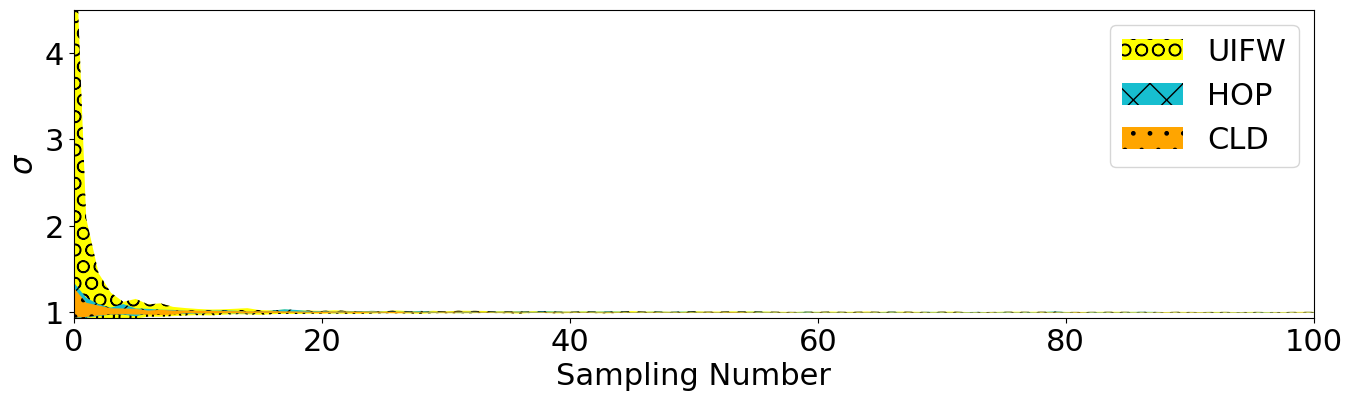

In [ ]:
import statsmodels.api as sm
plt.figure(figsize=(16,4))
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}
plt.rc('font', **font)


frac = 0.00

X = np.concatenate(UIFW_ratio_test,axis=1)
# mid = X.mean(axis=1)
# mid_s = sm.nonparametric.lowess(mid, list(range(len(mid))), frac = frac)
# var = X.var(axis=1)
upper = X.max(axis=1)
upper_s = sm.nonparametric.lowess(upper, list(range(len(upper))), frac = frac)
lower = X.min(axis=1)
plt.fill_between(list(range(len(lower))), lower, upper_s[:, 1], alpha=1, label="UIFW", facecolor='yellow', hatch='O')

X2 = np.concatenate(HOP_ratio_test,axis=1)
# mid2 = X2.mean(axis=1)
# mid2_s = sm.nonparametric.lowess(mid2, list(range(len(mid))), frac = frac)
# var = X2.var(axis=1)
upper = X2.max(axis=1)
upper_s = sm.nonparametric.lowess(upper, list(range(len(upper))), frac = frac)
lower = X2.min(axis=1)
plt.fill_between(list(range(len(lower))), lower, upper_s[:, 1], alpha=1, label="HOP", hatch='X', facecolor='tab:cyan')

X3 = np.concatenate(CLD_ratio_test,axis=1)
# mid3 = X3.mean(axis=1)
# mid3_s = sm.nonparametric.lowess(mid3, list(range(len(mid))), frac = frac)
# var = X3.var(axis=1)
upper = X3.max(axis=1)
upper_s = sm.nonparametric.lowess(upper, list(range(len(upper))), frac = frac)
lower = X3.min(axis=1)
plt.fill_between(list(range(len(lower))), lower, upper_s[:, 1], alpha=1, label="CLD", hatch='.', facecolor='orange')

# plt.plot(mid,linewidth=2,c='red', linestyle='dotted')
# plt.plot(mid2,linewidth=2,c='red', linestyle='dashed')
# plt.plot(mid3,linewidth=2,c='red', linestyle='dashdot')

plt.xlabel("Sampling Number")
plt.ylabel("$\sigma$")
plt.ylim(min(lower), 4.5)
plt.xlim(0,100)

plt.legend()
plt.show()

#SOTA

In [1]:
noise_rate = 100
label_noise_rate = 0.0

epochs = 50
batch_size = 32
models = ['CNN_L']
repetitions = 1
restore_best = True
lr = 0.0001
beta_1 = 0.5

calibration_models = ['ENIR']

# 'Dataset#2','UCI-HAR-Dataset'
datasets = ['Dataset#2']
for model in models:
  for calibrator_title in calibration_models:
    for problem in datasets:
          log_dir = f"./log/{problem}/"
          dataset = problems[problem]['dataset']
          n_classes = problems[problem]['n_classes']
          features = problems[problem]['features']
          sample_rate = problems[problem]['sample_rate']
          data_length_time = problems[problem]['data_length_time']
          n_h_block = problems[problem]['n_h_block']
          n_train_h_block = problems[problem]['n_train_h_block']
          n_valid_h_block = problems[problem]['n_valid_h_block']
          n_test_h_block = problems[problem]['n_test_h_block']
          h_moving_step = problems[problem]['h_moving_step']
          # train config index
          for tci in [0]:
              if calibrator_title in ['HistogramBinning', 'IsotonicRegression', 'ENIR', 'BBQ']:
                  last_activation = "softmax"
                  train_config[tci]["loss_function"].from_logits = False
              else:
                  last_activation = "softmax"
                  train_config[tci]["loss_function"].from_logits = False
              segments_time = problems[problem][model + '/segments_time']
              segments_overlap = problems[problem]['segments_overlaps']
              decision_time = problems[problem][model + '/decision_times']
              decision_overlap = problems[problem]['decision_overlaps']
              classifier = eval(model)(classes=n_classes,
                                         n_features=len(features),
                                         segments_size=int(segments_time * sample_rate),
                                         segments_overlap=segments_overlap,
                                         decision_size=int(decision_time * sample_rate),
                                         decision_overlap=decision_overlap,
                                         loss_metric=train_config[tci]["loss_metric"],
                                         loss_function=train_config[tci]["loss_function"],
                                         lr=lr,
                                         beta_1=beta_1,
                                         last_activation=last_activation,
                                         training=False)
              mc_classifier = eval(model)(classes=n_classes,
                                         n_features=len(features),
                                         segments_size=int(segments_time * sample_rate),
                                         segments_overlap=segments_overlap,
                                         decision_size=int(decision_time * sample_rate),
                                         decision_overlap=decision_overlap,
                                         loss_metric=train_config[tci]["loss_metric"],
                                         loss_function=train_config[tci]["loss_function"],
                                         lr=lr,
                                         beta_1=beta_1,
                                         last_activation=last_activation,
                                         training=True)
                # cross-validation
              # cross-validation
              start = datetime.now()

              add_noise = noise_rate < 100
              data_blocks = [i for i in range(n_h_block)]
              n_vt = (n_valid_h_block + n_test_h_block)
              n_iteration = int((n_h_block - n_vt) / h_moving_step)
              i = 0
              training_container = data_blocks[0:i] + data_blocks[i + n_vt:n_h_block]
              train_blocks = training_container[:n_train_h_block]
              valid_blocks = data_blocks[i: i + n_valid_h_block]
              test_blocks = data_blocks[i + n_valid_h_block: i + n_vt]
              db = Dataset2(dataset,
                                sample_rate,
                                features=features,
                                window_time=segments_time,
                                window_overlap_percentage=segments_overlap,
                                decision_time=decision_time,
                                decision_overlap_percentage=decision_overlap,
                                add_noise=add_noise,
                                noise_rate=noise_rate,
                                label_noise_rate=label_noise_rate,
                                train_blocks=train_blocks,
                                valid_blocks=valid_blocks,
                                test_blocks=test_blocks,
                                data_length_time=data_length_time)
              db.load_data(n_classes=n_classes, method=classifier.get_data_arrangement())

              all_statistics, valid_ratio_tests = h_block_analyzer(db_path=dataset,
                                                                     sample_rate=sample_rate,
                                                                     features=features,
                                                                     n_classes=n_classes,
                                                                     noise_rate=noise_rate,
                                                                     label_noise_rate=label_noise_rate,
                                                                     segments_time=segments_time,
                                                                     segments_overlap=segments_overlap,
                                                                     decision_time=decision_time,
                                                                     decision_overlap=decision_overlap,
                                                                     classifier=classifier,
                                                                     mc_classifier=mc_classifier,
                                                                     last_activation=last_activation,
                                                                     calibrator_title=calibrator_title,
                                                                     mc_sn=problems[problem]['M'],
                                                                     epochs=epochs,
                                                                     batch_size=batch_size,
                                                                     data_length_time=data_length_time,
                                                                     n_h_block=n_h_block,
                                                                     n_train_h_block=n_train_h_block,
                                                                     n_valid_h_block=n_valid_h_block,
                                                                     n_test_h_block=n_test_h_block,
                                                                     h_moving_step=h_moving_step,
                                                                     monitor_metric=train_config[tci]["monitor_metric"],
                                                                     monitor_mode=train_config[tci]["monitor_mode"],
                                                                     restore_best=restore_best,
                                                                     repetitions=repetitions)
              end = datetime.now()
              running_time = end - start
              for prediction_method in all_statistics.keys():
                    # Summarizing the results of cross-validation
                    data = {}
                    data['dataset'] = dataset
                    data['prediction_method'] = prediction_method
                    data['class'] = str(n_classes)
                    loss_metric = train_config[tci]["loss_metric"]
                    data['loss_metric'] = loss_metric if type(loss_metric) == str else loss_metric.__name__
                    loss_function = train_config[tci]["loss_function"]
                    data['loss_function'] = loss_function if type(loss_function) == str else str(loss_function)
                    data['lr'] = lr
                    data['beta_1'] = beta_1
                    data['monitor_metric'] = train_config[tci]["monitor_metric"]
                    data['monitor_mode'] = train_config[tci]["monitor_mode"]
                    data['restore_best'] = str(restore_best)
                    data['features'] = str(features)
                    data['sample_rate'] = str(sample_rate)
                    data['noise_rate'] = str(noise_rate)
                    data['label_noise_rate'] = str(label_noise_rate)
                    data['epochs'] = str(epochs)
                    data['batch_size'] = str(batch_size)
                    data['data_length_time'] = str(data_length_time)
                    data['repetitions'] = str(repetitions)
                    data['n_h_block'] = str(n_h_block)
                    data['n_train_h_block'] = str(n_train_h_block)
                    data['n_valid_h_block'] = str(n_valid_h_block)
                    data['n_test_h_block'] = str(n_test_h_block)
                    data['h_moving_step'] = str(h_moving_step)
                    data['segments_time'] = str(segments_time)
                    data['segments_overlap'] = str(segments_overlap)
                    data['inner_classifier'] = str(model)
                    data['calibration'] = str(calibrator_title)
                    data['M'] = problems[problem]['M']
                    data['datetime'] = datetime.now().strftime("%Y:%m:%d %H:%M:%S")
                    data['running_time'] = str(running_time.seconds) + " seconds"
                    data['n_params'] = classifier.count_params()
                    data['segments_time'] = timedelta(seconds=int(segments_time))
                    data['segments_overlap'] = segments_overlap
                    data['decision_time'] = timedelta(seconds=int(decision_time))
                    data['decision_overlap'] = decision_overlap
                    statistics_summary = {}
                    for key in all_statistics[prediction_method].keys():
                        for inner_key in all_statistics[prediction_method][key].keys():
                            statistics_summary[key + '_' + inner_key + '_mean'] = np.average(
                                all_statistics[prediction_method][key][inner_key])
                            statistics_summary[key + '_' + inner_key + '_std'] = np.std(
                                all_statistics[prediction_method][key][inner_key])
                            statistics_summary[key + '_' + inner_key + '_max'] = np.max(
                                all_statistics[prediction_method][key][inner_key])
                            statistics_summary[key + '_' + inner_key + '_min'] = np.min(
                                all_statistics[prediction_method][key][inner_key])
                    data.update(statistics_summary)
                    # Save information
                    save_result(log_dir=log_dir, data=data)

NameError: name 'problems' is not defined